In [2]:
data_dir = '/mnt/c/Users/ferna/Desktop/SingleCell/data/'
%run -i '../../utils/load_data_short.py'

# import sys
# sys.path.insert(0, '../../utils/')
import importlib
# importlib.reload(scp)
# importlib.reload(spu)
# sns.reset_orig()
from scipy.stats import chisquare
from scipy.stats import combine_pvalues
%run -i '../../utils/test_functions.py'

import matplotlib as mpl
mpl.rcParams["mathtext.fontset"] = "stix"
mpl.rcParams['pdf.fonttype'] = 42

#from tqdm import tqdm

In [3]:
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import pdist
from sklearn.metrics.pairwise import euclidean_distances

# def get_signature_score(PSI_tab, exon):
#     exon_score = (PSI_tab.loc[exon] - PSI_tab.mean())/(PSI_tab.std())
#     return exon_score.dropna()

def get_auto_correlation(exon_score, pca):
    N = len(exon_score)
    weights = euclidean_distances(pca.loc[exon_score.index][['PC1', 'PC2']])
    W = weights.sum().sum()
    
def get_signature_score(PSI_tab, exon):
    exon_score = (PSI_tab.loc[exon] - PSI_tab.mean())/(PSI_tab.std())
    return exon_score.dropna()


def get_distance_matrix(pca, k=10):
    nbrs = NearestNeighbors(n_neighbors=k).fit(pca[['PC1', 'PC2']])
    distances, indices = nbrs.kneighbors(pca[['PC1', 'PC2']])
    
    cells = list(pca.index)
    
    W = pd.DataFrame(np.zeros((len(cells), len(cells))))
    W.columns = cells
    W.index = cells
    
    for i in tqdm(range(len(cells))):
        cell_i = cells[i]
        sigma = np.max(distances[i])
        for j in range(len(distances[i])):
            
            cell_j = cells[indices[i][j]]
            
            d = distances[i][j]
            w = np.exp(-(d**2)/(sigma**2))
#             w = np.exp(-(d**2)/(sigma))
            
            W.loc[cell_i, cell_j] = w
    
    
    
    return W
    
# def get_C(PSI_tab, W, exon):
#     obs_cells = PSI_tab.loc[exon].dropna().index
#     x = (PSI_tab.loc[exon, obs_cells].values.reshape(-1, 1) - PSI_tab.loc[exon, obs_cells].values.reshape(1, -1))
#     w = W.loc[obs_cells, obs_cells]
#     num = (len(obs_cells)-1)*((w*(x**2)).sum().sum())
#     den = (2*w.sum().sum())*np.sum((PSI_tab.loc[exon, obs_cells] - PSI_tab.loc[exon, obs_cells].mean())**2)
#     C = num/den
#     score = 1 - C
#     return score

# def get_C(PSI_tab, W, exon):
    
#     exon_score = get_signature_score(PSI_tab, exon)
    
    
#     obs_cells = exon_score.dropna().index
#     x = (exon_score.values.reshape(-1, 1) - exon_score.values.reshape(1, -1))
#     w = W.loc[obs_cells, obs_cells]
#     num = (len(obs_cells)-1)*((w*(x**2)).sum().sum())
#     den = (2*w.sum().sum())*np.sum((exon_score - exon_score.mean())**2)
    
#     C = num/den
#     score = 1 - C
#     return score

def get_C(exon_score, W):
    exon_score = exon_score.dropna()
    obs_cells = exon_score.index
    x = (exon_score.values.reshape(-1, 1) - exon_score.values.reshape(1, -1))
    w = W.loc[obs_cells, obs_cells]
    num = (len(obs_cells)-1)*((w*(x**2)).sum().sum())
    den = (2*w.sum().sum())*np.sum((exon_score - exon_score.mean())**2)
    
    C = num/den
    score = 1 - C
    return score

def get_C_set(PSI_tab, W, exon_list):
    obs_cells = PSI_tab.loc[exon].dropna().index
    x = (PSI_tab.loc[exon, obs_cells].values.reshape(-1, 1) - PSI_tab.loc[exon, obs_cells].values.reshape(1, -1))
    w = W.loc[obs_cells, obs_cells]
    num = (len(obs_cells)-1)*((w*(x**2)).sum().sum())
    den = (2*w.sum().sum())*np.sum((PSI_tab.loc[exon, obs_cells] - PSI_tab.loc[exon, obs_cells].mean())**2)
    C = num/den
    score = 1 - C
    return score

In [4]:
chen_int_genes, chen_int_exons = spu.get_int_events(chen_PSI, chen_mrna_counts, 0.05)
chen_int_exons = [x for x in chen_int_exons if x in mrna_per_event_chen.index]
chen_filtered_lax = filter_psi(chen_PSI, chen_int_exons, mrna_per_event_chen, chen_coverage_tab['SJ_coverage'], 
                           chen_read_counts, mrna_min=10, reads_min=0, cell_min=0.05)

chen_filtered_lax_reads = filter_psi(chen_PSI, chen_int_exons, mrna_per_event_chen, chen_coverage_tab['SJ_coverage'], 
                           chen_read_counts, mrna_min=0, reads_min=10, cell_min=0.05)

song_int_genes, song_int_exons = spu.get_int_events(song_PSI, song_mrna_counts, 0.05)
song_int_exons = [x for x in song_int_exons if x in mrna_per_event_song.index]
song_filtered_lax = filter_psi(song_PSI, song_int_exons, mrna_per_event_song, song_coverage_tab['SJ_coverage'], 
                           song_read_counts, mrna_min=10, reads_min=0, cell_min=0.05)

song_filtered_lax_reads = filter_psi(song_PSI, song_int_exons, mrna_per_event_song, song_coverage_tab['SJ_coverage'], 
                           song_read_counts, mrna_min=0, reads_min=10, cell_min=0.05)

trapnell_int_genes, trapnell_int_exons = spu.get_int_events(trapnell_PSI, trapnell_mrna_counts, 0.05)
trapnell_int_exons = [x for x in trapnell_int_exons if x in mrna_per_event_trapnell.index]
trapnell_filtered_lax = filter_psi(trapnell_PSI, trapnell_int_exons, mrna_per_event_trapnell, trapnell_coverage_tab['SJ_coverage'], 
                           trapnell_read_counts, mrna_min=10, reads_min=0, cell_min=0.05)

trapnell_filtered_lax_reads = filter_psi(trapnell_PSI, trapnell_int_exons, mrna_per_event_trapnell, trapnell_coverage_tab['SJ_coverage'], 
                           trapnell_read_counts, mrna_min=0, reads_min=10, cell_min=0.05)

lescroart_int_genes, lescroart_int_exons = spu.get_int_events(lescroart_PSI, lescroart_mrna_counts, 0.05)
lescroart_int_exons = [x for x in lescroart_int_exons if x in mrna_per_event_lescroart.index]
lescroart_filtered_lax = filter_psi(lescroart_PSI, lescroart_int_exons, mrna_per_event_lescroart, lescroart_coverage_tab['SJ_coverage'], 
                           lescroart_read_counts, mrna_min=10, reads_min=0, cell_min=0.05)

lescroart_filtered_lax_reads = filter_psi(lescroart_PSI, lescroart_int_exons, mrna_per_event_lescroart, lescroart_coverage_tab['SJ_coverage'], 
                           lescroart_read_counts, mrna_min=0, reads_min=10, cell_min=0.05)

In [4]:
# Ws = get_distance_matrix(chen_pca_clust, 50)
# figsize(15, 15)
# sns.heatmap(Ws.loc[chen_pca_clust.pseudotime.sort_values().index, 
#                       chen_pca_clust.pseudotime.sort_values().index],cmap=cm.bone_r)
# plt.show()

In [5]:
def get_signature_matrix(PSI_tab):
    return (PSI_tab - PSI_tab.mean())/PSI_tab.std()

def run_autocorrelation_test(PSI_tab, mrna_counts, 
                             pca, Ws = '', cluster_frac = 1, mock_rounds = 3, min_obs = 0.5, psi_int = 0.2, plot_weights=True,
                            norm_PSI=''):
    total_cells = len(PSI_tab.columns)
    k_cells = int(total_cells*cluster_frac)
    
    if len(Ws) == 0:
        Ws = get_distance_matrix(pca, k_cells)
        if plot_weights:
            figsize(10, 10)
            try:
                sns.heatmap(Ws.loc[pca.pseudotime.sort_values().index, 
                                  pca.pseudotime.sort_values().index],cmap=cm.bone_r)
            except:
                sns.clustermap(Ws,cmap=cm.bone_r)
            plt.show()
    
    int_genes, int_exons = spu.get_int_events(PSI_tab, mrna_counts, psi_int)
    observed_exons = PSI_tab.index[PSI_tab.isna().mean(axis=1) <= (1-min_obs)]
    test_exons = [x for x in observed_exons if x in int_exons]

    if len(norm_PSI) == 0:
        norm_PSI = get_signature_matrix(PSI_tab)
        

    exon_list = []
    C_scores = []
#     print(test_exons)
    for exon in tqdm(test_exons):
        exon_df = norm_PSI.loc[exon] # to make things faster
        exon_score = get_C(exon_df, Ws)
        if exon_score >= 0:
            C_scores.append(exon_score)
            exon_list.append(exon)

            for i in range(mock_rounds):
                scramble_cells = r.choice(norm_PSI.columns, total_cells, replace=False)
                mock_PSI = pd.DataFrame(norm_PSI.loc[exon, scramble_cells]).T
                mock_PSI.columns = PSI_tab.columns
                mock_df = mock_PSI.loc[exon]
                mock_score = get_C(mock_df, Ws)
                if mock_score >= 0:
                    C_scores.append(mock_score)
                    exon_list.append('mock_'+exon+'_'+str(i))


    pvals = pd.DataFrame()
    pvals['C_score'] = C_scores
    pvals.index = exon_list
    
    
    n = len(pvals.C_score)
    pval_list = []

    for exon in tqdm(pvals.index):
        C = pvals.loc[exon, 'C_score']
        x = np.sum(pvals.C_score > C)
        pvalue = (x+1)/(n+1)
        pval_list.append(pvalue)

    pvals['pvals'] = pval_list
    
    
    return pvals

HBox(children=(IntProgress(value=0, max=488), HTML(value='')))

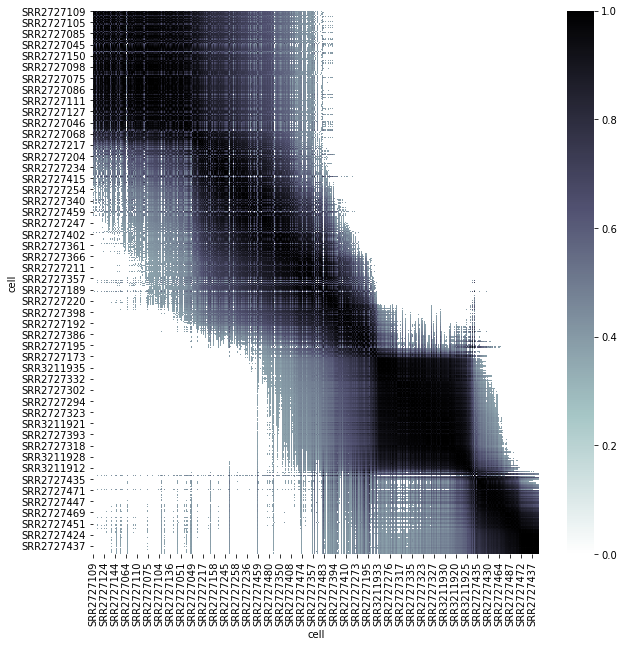

HBox(children=(IntProgress(value=0, max=429), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1245), HTML(value='')))

In [184]:
pval_chen = run_autocorrelation_test(chen_PSI, chen_mrna_counts, 
                             chen_pca_clust, cluster_frac = 0.5, mock_rounds = 3, min_obs = 0.5, 
                         psi_int = 0.2, plot_weights=True)

HBox(children=(IntProgress(value=0, max=488), HTML(value='')))

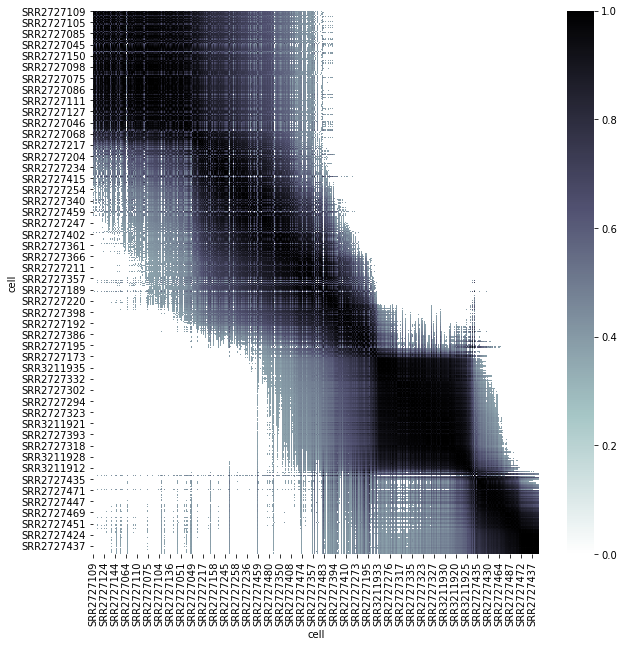

HBox(children=(IntProgress(value=0, max=429), HTML(value='')))

HBox(children=(IntProgress(value=0, max=3240), HTML(value='')))

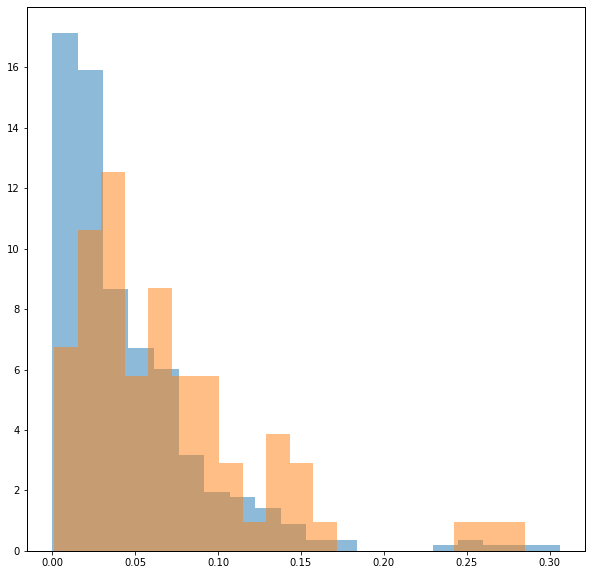

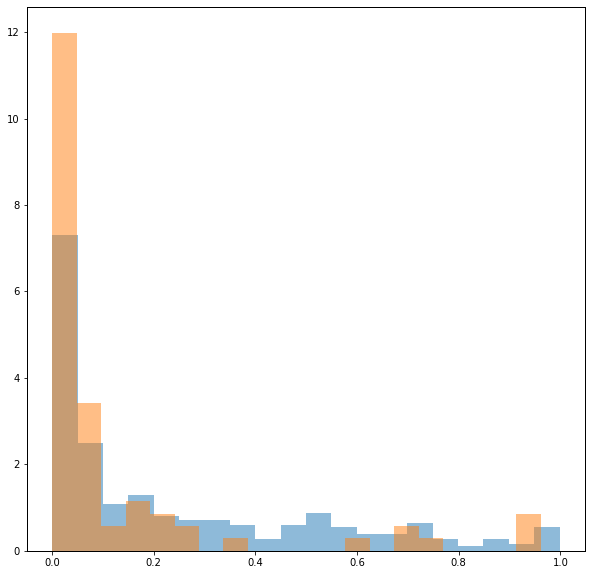

In [208]:
pval_chen = run_autocorrelation_test(chen_PSI, chen_mrna_counts, 
                             chen_pca_clust, cluster_frac = 0.5, mock_rounds = 10, min_obs = 0.5, 
                         psi_int = 0.2, plot_weights=True)
chen_int_genes, chen_int_exons = spu.get_int_events(chen_PSI, chen_mrna_counts, 0.2)
observed_exons = chen_PSI.index[chen_PSI.isna().mean(axis=1) <= 0.5]
test_exons = [x for x in observed_exons if x in chen_int_exons]

selected_mrna = [x for x in chen_filtered_lax[0].index[chen_filtered_lax[0].isna().mean(axis=1) <= 0.5] if x in pval_chen.index]
plt.hist(pval_chen.loc[[x for x in pval_chen.index if 'mock_' not in x], 'C_score'], density=True, alpha=0.5, bins=20)
plt.hist(pval_chen.loc[selected_mrna, 'C_score'], density=True, alpha=0.5, bins=20)
plt.show()

plt.hist(pval_chen.loc[[x for x in pval_chen.index if x in test_exons],'pvals'], alpha = 0.5, density=True, bins=20)
plt.hist(pval_chen.loc[selected_mrna,'pvals'], alpha = 0.5, density=True, bins=20)
plt.show()


pval_chen.to_csv('chen_autocorrelation_pvalues.tab', sep='\t', header=True, index=True)


HBox(children=(IntProgress(value=0, max=202), HTML(value='')))

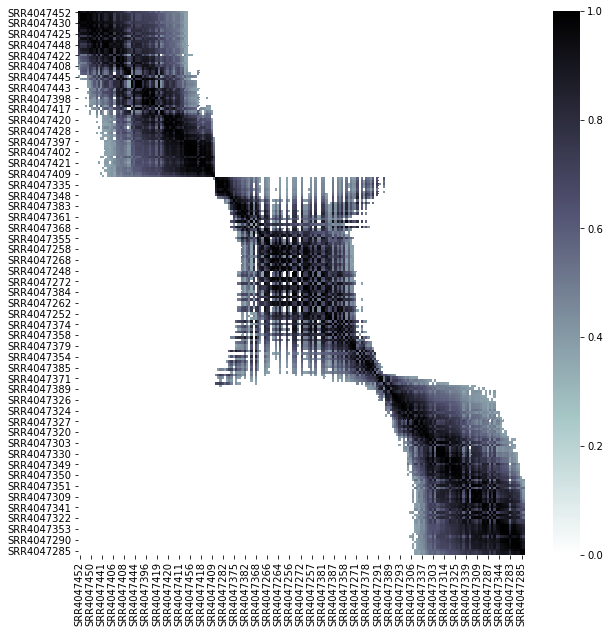

HBox(children=(IntProgress(value=0, max=238), HTML(value='')))

HBox(children=(IntProgress(value=0, max=2475), HTML(value='')))

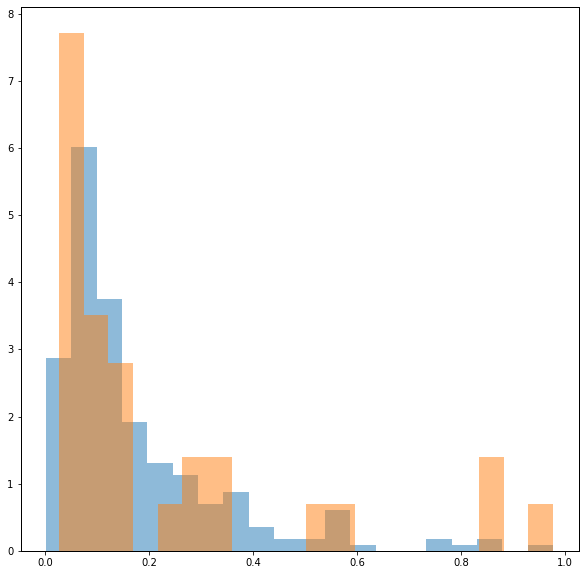

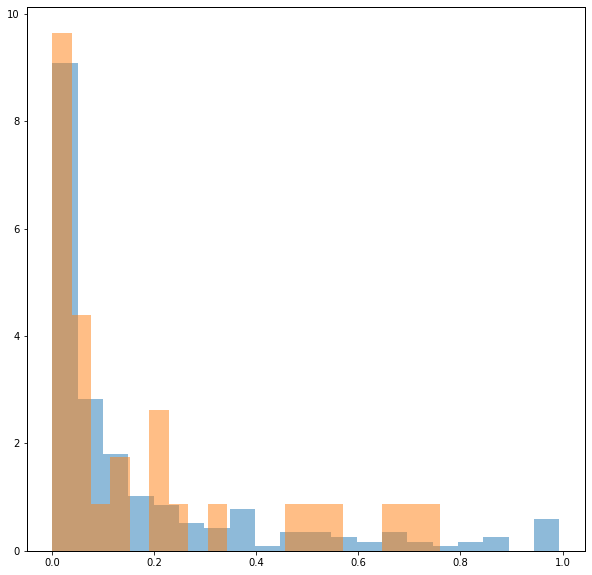

In [209]:
pval_song = run_autocorrelation_test(song_PSI, song_mrna_counts, 
                             song_pca_clust, cluster_frac = 0.25, mock_rounds = 10, min_obs = 0.5, 
                         psi_int = 0.2, plot_weights=True)
song_int_genes, song_int_exons = spu.get_int_events(song_PSI, song_mrna_counts, 0.2)
observed_exons = song_PSI.index[song_PSI.isna().mean(axis=1) <= 0.5]
test_exons = [x for x in observed_exons if x in song_int_exons]

selected_mrna = [x for x in song_filtered_lax[0].index[song_filtered_lax[0].isna().mean(axis=1) <= 0.5] if x in pval_song.index]
plt.hist(pval_song.loc[[x for x in pval_song.index if 'mock_' not in x], 'C_score'], density=True, alpha=0.5, bins=20)
plt.hist(pval_song.loc[selected_mrna, 'C_score'], density=True, alpha=0.5, bins=20)
plt.show()

plt.hist(pval_song.loc[[x for x in pval_song.index if x in test_exons],'pvals'], alpha = 0.5, density=True, bins=20)
plt.hist(pval_song.loc[selected_mrna,'pvals'], alpha = 0.5, density=True, bins=20)
plt.show()

pval_song.to_csv('song_autocorrelation_pvalues.tab', sep='\t', header=True, index=True)


HBox(children=(IntProgress(value=0, max=231), HTML(value='')))

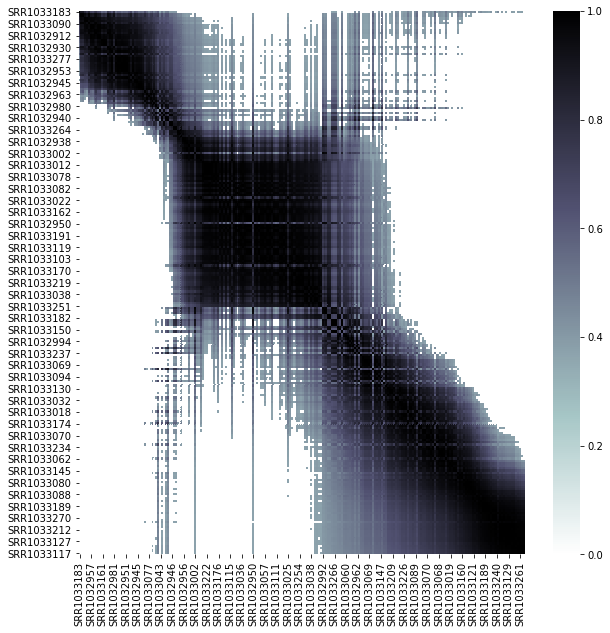

HBox(children=(IntProgress(value=0, max=242), HTML(value='')))

HBox(children=(IntProgress(value=0, max=8698), HTML(value='')))

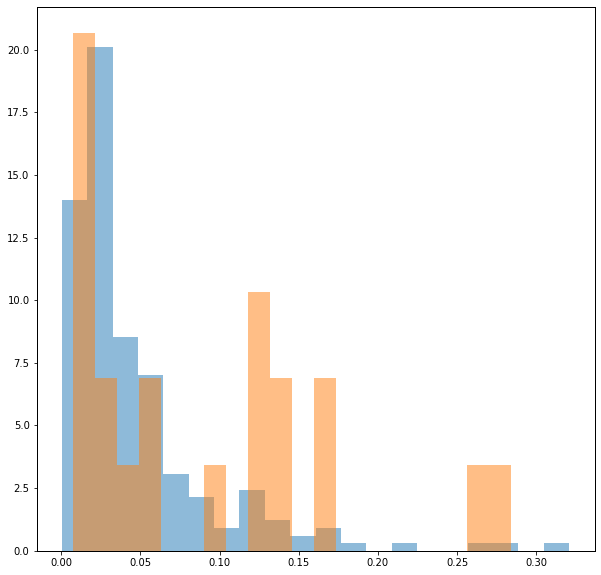

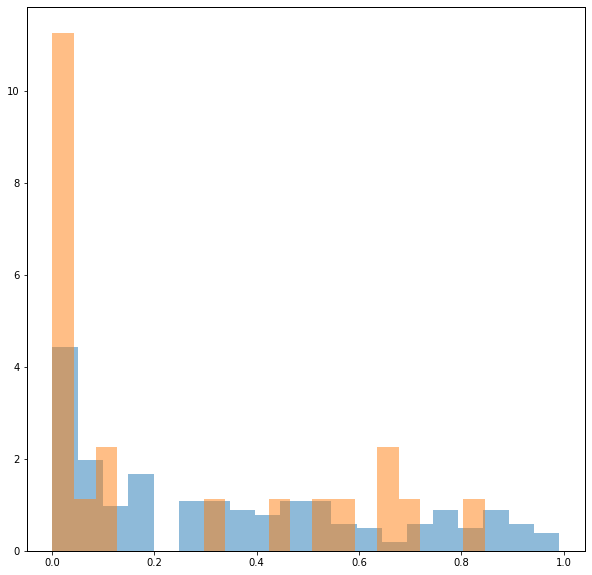

In [210]:
pval_trapnell = run_autocorrelation_test(trapnell_PSI, trapnell_mrna_counts, 
                             trapnell_pca_clust, cluster_frac = 0.5, mock_rounds = 50, min_obs = 0.5, 
                         psi_int = 0.2, plot_weights=True)

trapnell_int_genes, trapnell_int_exons = spu.get_int_events(trapnell_PSI, trapnell_mrna_counts, 0.2)
observed_exons = trapnell_PSI.index[trapnell_PSI.isna().mean(axis=1) <= 0.5]
test_exons = [x for x in observed_exons if x in trapnell_int_exons]


selected_mrna = [x for x in trapnell_filtered_lax[0].index[trapnell_filtered_lax[0].isna().mean(axis=1) <= 0.5] if x in pval_trapnell.index]
plt.hist(pval_trapnell.loc[[x for x in pval_trapnell.index if 'mock_' not in x], 'C_score'], density=True, alpha=0.5, bins=20)
plt.hist(pval_trapnell.loc[selected_mrna, 'C_score'], density=True, alpha=0.5, bins=20)
plt.show()

plt.hist(pval_trapnell.loc[[x for x in pval_trapnell.index if x in test_exons],'pvals'], alpha = 0.5, density=True, bins=20)
plt.hist(pval_trapnell.loc[selected_mrna,'pvals'], alpha = 0.5, density=True, bins=20)
plt.show()

pval_trapnell.to_csv('trapnell_autocorrelation_pvalues.tab', sep='\t', header=True, index=True)

HBox(children=(IntProgress(value=0, max=513), HTML(value='')))

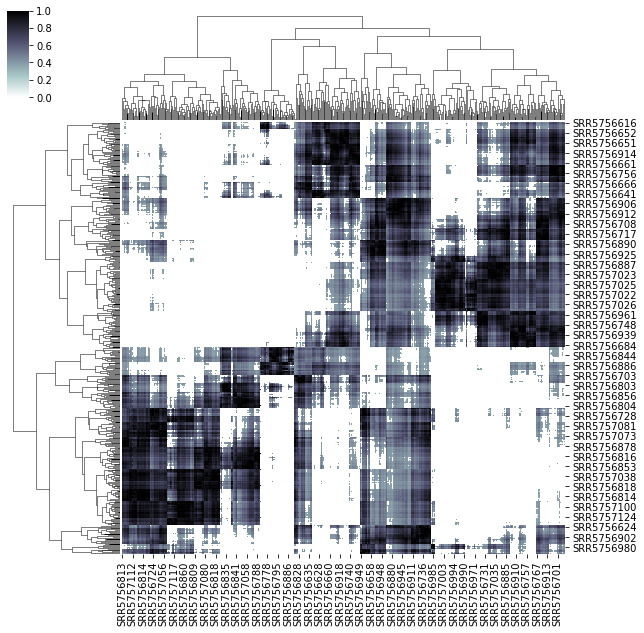

HBox(children=(IntProgress(value=0, max=283), HTML(value='')))

HBox(children=(IntProgress(value=0, max=10333), HTML(value='')))

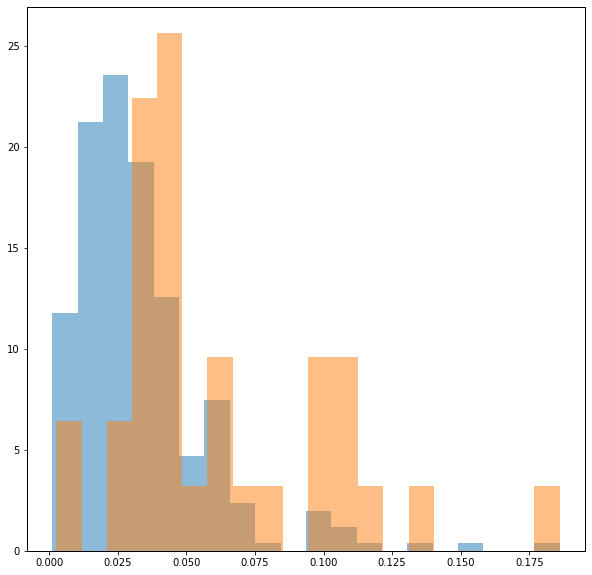

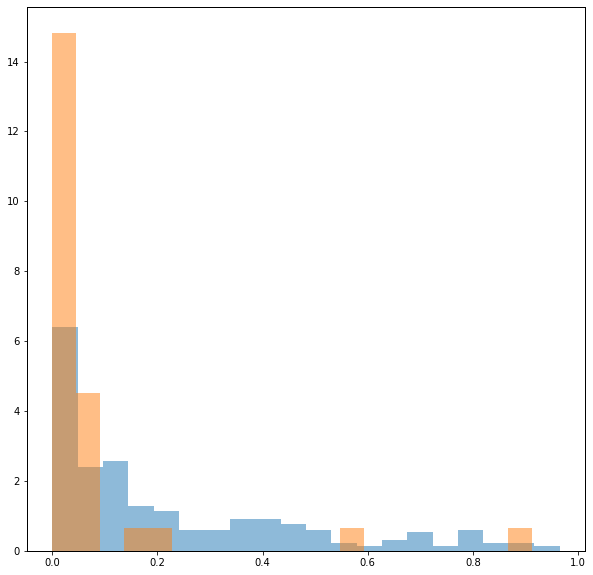

In [211]:
pval_lescroart = run_autocorrelation_test(lescroart_PSI, lescroart_mrna_counts, 
                             lescroart_pca_clust, cluster_frac = 0.5, mock_rounds = 50, min_obs = 0.5, 
                         psi_int = 0.2)

lescroart_int_genes, lescroart_int_exons = spu.get_int_events(lescroart_PSI, lescroart_mrna_counts, 0.2)
observed_exons = lescroart_PSI.index[lescroart_PSI.isna().mean(axis=1) <= 0.5]
test_exons = [x for x in observed_exons if x in lescroart_int_exons]


selected_mrna = [x for x in lescroart_filtered_lax[0].index[lescroart_filtered_lax[0].isna().mean(axis=1) <= 0.5] if x in pval_lescroart.index]
plt.hist(pval_lescroart.loc[[x for x in pval_lescroart.index if 'mock_' not in x], 'C_score'], density=True, alpha=0.5, bins=20)
plt.hist(pval_lescroart.loc[selected_mrna, 'C_score'], density=True, alpha=0.5, bins=20)
plt.show()

plt.hist(pval_lescroart.loc[[x for x in pval_lescroart.index if x in test_exons],'pvals'], alpha = 0.5, density=True, bins=20)
plt.hist(pval_lescroart.loc[selected_mrna,'pvals'], alpha = 0.5, density=True, bins=20)
plt.show()

pval_lescroart.to_csv('lescroart_autocorrelation_pvalues.tab', sep='\t', header=True, index=True)

HBox(children=(IntProgress(value=0, max=488), HTML(value='')))

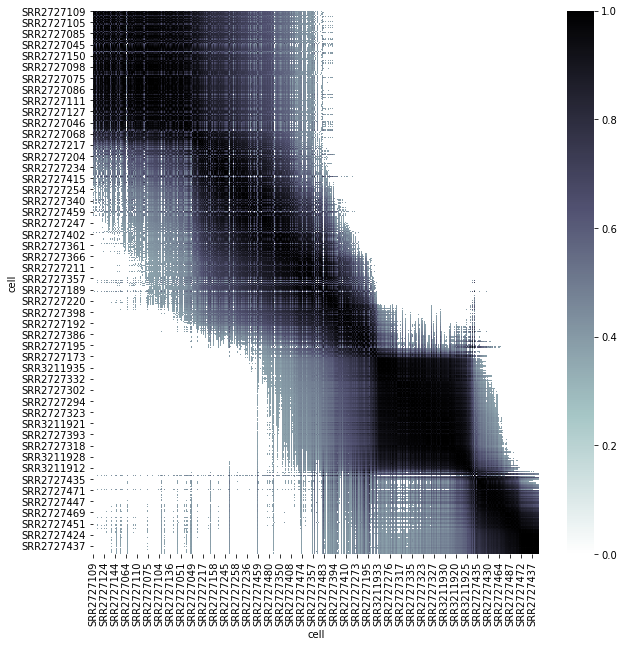

In [158]:
Ws = get_distance_matrix(chen_pca_clust, 244)
figsize(10, 10)
sns.heatmap(Ws.loc[chen_pca_clust.pseudotime.sort_values().index, 
                      chen_pca_clust.pseudotime.sort_values().index],cmap=cm.bone_r)
plt.show()

In [116]:
## Cadm2_1; put this somewhere else

In [86]:
cadm1_2 = chen_filtered_lax[0].loc['Cadm1_2'].dropna()
spearmanr(chen_pca_clust.loc[cadm1_2.index, 'pseudotime'], cadm1_2)

SpearmanrResult(correlation=0.5184898254993583, pvalue=1.195723153785795e-07)

In [87]:
cadm1_2 = chen_PSI.loc['Cadm1_2'].dropna()
spearmanr(chen_pca_clust.loc[cadm1_2.index, 'pseudotime'], cadm1_2)

SpearmanrResult(correlation=0.09657794557273425, pvalue=0.07405118790694705)

In [54]:
chen_filtered_lax[0].loc['Cadm1_2'].dropna().mean()

0.4934900572916584

In [55]:
chen_PSI.loc['Cadm1_2'].dropna().mean()

0.43997665672321845

In [59]:
chen_filtered_lax[0].loc['Cadm1_2'].dropna().var()

0.1063209743267589

In [60]:
chen_PSI.loc['Cadm1_2'].dropna().var()

0.159176203762512

In [218]:
chen_PSI.index[np.abs(0.5 - chen_PSI.mean(axis = 1))>=0.4]


chen_PSI.index[np.abs(0.5 - chen_PSI.mean(axis = 1))>=0.3]

Index(['0610007P14Rik_1', '0610007P14Rik_2', '0610007P14Rik_3',
       '0610007P14Rik_4', '0610007P14Rik_5', '0610007P14Rik_6',
       '0610010F05Rik_4', '0610010F05Rik_5', '0610010K14Rik_5',
       '0610010K14Rik_7',
       ...
       'Zyx_1', 'Zyx_2', 'Zyx_3', 'Zzz3_6', 'l7Rn6_2', 'l7Rn6_3', 'l7Rn6_4',
       'l7Rn6_5', 'l7Rn6_7', 'l7Rn6_8'],
      dtype='object', length=8066)

In [222]:
# W_chen = get_distance_matrix(chen_pca_clust, k=244)

pval_chen_05_10 = run_autocorrelation_test(chen_PSI.loc[chen_PSI.index[np.abs(0.5 - chen_PSI.mean(axis = 1))>=0.4]], 
                                           chen_mrna_counts, 
                             chen_pca_clust, Ws=W_chen, cluster_frac = 0.5, mock_rounds = 3, min_obs = 0.5, 
                         psi_int = 0.05, plot_weights=True)

pval_chen_10_20 = run_autocorrelation_test(chen_PSI.loc[chen_PSI.index[np.abs(0.5 - chen_PSI.mean(axis = 1))>=0.3]], 
                                           chen_mrna_counts, 
                             chen_pca_clust, Ws=W_chen,  cluster_frac = 0.5, mock_rounds = 3, min_obs = 0.5, 
                         psi_int = 0.1, plot_weights=True)

pval_chen_20_30 = run_autocorrelation_test(chen_PSI.loc[chen_PSI.index[np.abs(0.5 - chen_PSI.mean(axis = 1))>=0.2]], 
                                           chen_mrna_counts, 
                             chen_pca_clust, Ws=W_chen,  cluster_frac = 0.5, mock_rounds = 3, min_obs = 0.5, 
                         psi_int = 0.2, plot_weights=True)

pval_chen_30_40 = run_autocorrelation_test(chen_PSI.loc[chen_PSI.index[np.abs(0.5 - chen_PSI.mean(axis = 1))>=0.1]], 
                                           chen_mrna_counts, 
                             chen_pca_clust, Ws=W_chen,  cluster_frac = 0.5, mock_rounds = 3, min_obs = 0.5, 
                         psi_int = 0.3, plot_weights=True)


pval_chen_40_50 = run_autocorrelation_test(chen_PSI, chen_mrna_counts, 
                             chen_pca_clust, Ws=W_chen,  cluster_frac = 0.5, mock_rounds = 3, min_obs = 0.5, 
                         psi_int = 0.4, plot_weights=True)

HBox(children=(IntProgress(value=0, max=452), HTML(value='')))

HBox(children=(IntProgress(value=0, max=879), HTML(value='')))

HBox(children=(IntProgress(value=0, max=295), HTML(value='')))

HBox(children=(IntProgress(value=0, max=652), HTML(value='')))

HBox(children=(IntProgress(value=0, max=186), HTML(value='')))

HBox(children=(IntProgress(value=0, max=472), HTML(value='')))

HBox(children=(IntProgress(value=0, max=132), HTML(value='')))

HBox(children=(IntProgress(value=0, max=404), HTML(value='')))

HBox(children=(IntProgress(value=0, max=111), HTML(value='')))

HBox(children=(IntProgress(value=0, max=365), HTML(value='')))

(array([20.18948356, 11.77719874,  5.46798513,  3.36491393,  0.84122848,
         0.42061424,  0.42061424,  0.42061424,  0.        ,  0.42061424]),
 array([1.70588941e-05, 2.30993441e-02, 4.61816293e-02, 6.92639145e-02,
        9.23461997e-02, 1.15428485e-01, 1.38510770e-01, 1.61593055e-01,
        1.84675340e-01, 2.07757626e-01, 2.30839911e-01]),
 <a list of 10 Patch objects>)

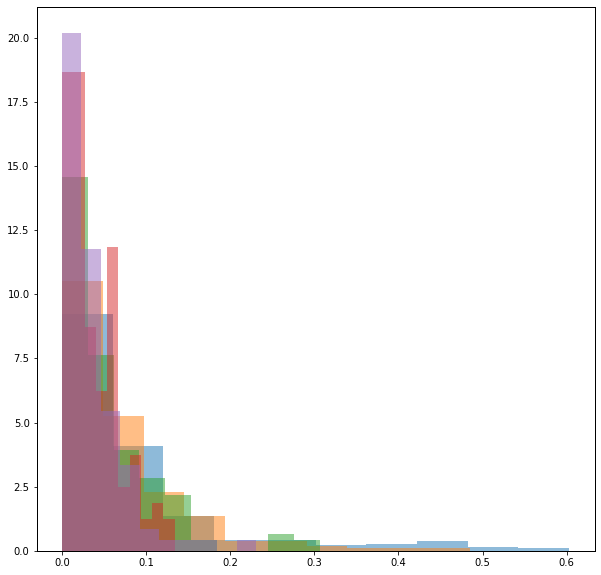

In [275]:
plt.hist(pval_chen_05_10.loc[[x for x in pval_chen_05_10.index if 'mock' not in x], 'C_score'], alpha=0.5, density=True)
plt.hist(pval_chen_10_20.loc[[x for x in pval_chen_10_20.index if 'mock' not in x], 'C_score'], alpha=0.5, density=True)
plt.hist(pval_chen_20_30.loc[[x for x in pval_chen_20_30.index if 'mock' not in x], 'C_score'], alpha=0.5, density=True)
plt.hist(pval_chen_30_40.loc[[x for x in pval_chen_30_40.index if 'mock' not in x], 'C_score'], alpha=0.5, density=True)
plt.hist(pval_chen_40_50.loc[[x for x in pval_chen_40_50.index if 'mock' not in x], 'C_score'], alpha=0.5, density=True)

In [230]:
get_C(chen_norm_PSI.loc['Rpn2_1'], W_chen)

0.4502545520728307

In [251]:
selected_mrna = [x for x in chen_filtered_lax[0].index[chen_filtered_lax[0].isna().mean(axis=1) <= 0.5] if x in pval_chen_05_10.index]


(array([2.47719498, 1.50513113, 1.12884835, 1.06613455, 0.62713797,
        0.72120867, 0.72120867, 0.50171038, 0.72120867, 0.56442417]),
 array([0.00113636, 0.10079545, 0.20045455, 0.30011364, 0.39977273,
        0.49943182, 0.59909091, 0.69875   , 0.79840909, 0.89806818,
        0.99772727]),
 <a list of 10 Patch objects>)

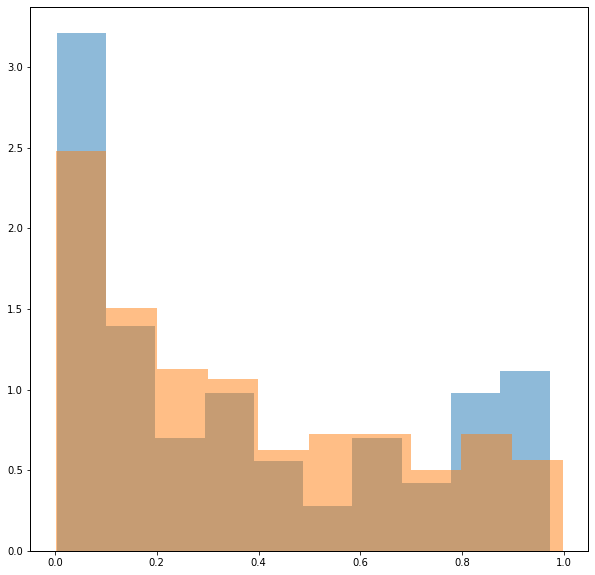

In [263]:
selected_mrna = [x for x in chen_filtered_lax[0].index[chen_filtered_lax[0].isna().mean(axis=1) <= 0.5] if x in pval_chen_05_10.index]

plt.hist(pval_chen_05_10.loc[[x for x in pval_chen_05_10.index if x in selected_mrna]].pvals, density=True, alpha=0.5)
plt.hist(pval_chen_05_10.loc[[x for x in pval_chen_05_10.index if 'mock' not in x]].pvals, density=True, alpha=0.5)

In [267]:
(chen_PSI.isna().mean(axis=1) <= 0.5) & (chen_PSI.isna().mean(axis=1) >= 0.4)

0610007P14Rik_1    False
0610007P14Rik_2    False
0610007P14Rik_3    False
0610007P14Rik_4    False
0610007P14Rik_5    False
0610007P14Rik_6    False
0610010F05Rik_4    False
0610010F05Rik_5    False
0610010K14Rik_1    False
0610010K14Rik_2    False
0610010K14Rik_3    False
0610010K14Rik_4    False
0610010K14Rik_5    False
0610010K14Rik_6    False
0610010K14Rik_7    False
0610010K14Rik_8    False
0610010K14Rik_9    False
0610011F06Rik_1    False
0610037L13Rik_3    False
0610040B10Rik_1    False
1110002L01Rik_1    False
1110004E09Rik_1    False
1110004E09Rik_2    False
1110008F13Rik_1    False
1110008F13Rik_2    False
1110019D14Rik_1    False
1110034G24Rik_1    False
1110037F02Rik_1    False
1110037F02Rik_3    False
1110037F02Rik_4     True
                   ...  
Zscan22_1          False
Zscan22_2          False
Zscan26_1          False
Zscan26_2          False
Zscan29_1          False
Zswim4_3           False
Zswim7_1           False
Zswim7_2           False
Zswim7_3           False


In [272]:
# W_chen = get_distance_matrix(chen_pca_clust, k=244)

pval_chen_50_60 = run_autocorrelation_test(chen_PSI.loc[chen_PSI.index[(chen_PSI.isna().mean(axis=1) <= 0.5) & (chen_PSI.isna().mean(axis=1) >= 0.4)]], 
                                           chen_mrna_counts, 
                             chen_pca_clust, Ws=W_chen, cluster_frac = 0.5, mock_rounds = 3, min_obs = 0.5, 
                         psi_int = 0.2, plot_weights=True)

pval_chen_60_70 = run_autocorrelation_test(chen_PSI.loc[chen_PSI.index[(chen_PSI.isna().mean(axis=1) <= 0.4) & (chen_PSI.isna().mean(axis=1) >= 0.3)]], 
                                           chen_mrna_counts, 
                             chen_pca_clust, Ws=W_chen,  cluster_frac = 0.5, mock_rounds = 3, min_obs = 0.5, 
                         psi_int = 0.2, plot_weights=True)

pval_chen_70_80 = run_autocorrelation_test(chen_PSI.loc[chen_PSI.index[(chen_PSI.isna().mean(axis=1) <= 0.3) & (chen_PSI.isna().mean(axis=1) >= 0.2)]], 
                                           chen_mrna_counts, 
                             chen_pca_clust, Ws=W_chen,  cluster_frac = 0.5, mock_rounds = 3, min_obs = 0.5, 
                         psi_int = 0.2, plot_weights=True)

pval_chen_80_90 = run_autocorrelation_test(chen_PSI.loc[chen_PSI.index[(chen_PSI.isna().mean(axis=1) <= 0.2) & (chen_PSI.isna().mean(axis=1) >= 0.1)]], 
                                           chen_mrna_counts, 
                             chen_pca_clust, Ws=W_chen,  cluster_frac = 0.5, mock_rounds = 3, min_obs = 0.5, 
                         psi_int = 0.2, plot_weights=True)


pval_chen_90_1000 = run_autocorrelation_test(chen_PSI, chen_mrna_counts, 
                             chen_pca_clust, Ws=W_chen,  cluster_frac = 0.5, mock_rounds = 3, min_obs = 0.9, 
                         psi_int = 0.2, plot_weights=True)

HBox(children=(IntProgress(value=0, max=126), HTML(value='')))

HBox(children=(IntProgress(value=0, max=389), HTML(value='')))

HBox(children=(IntProgress(value=0, max=92), HTML(value='')))

HBox(children=(IntProgress(value=0, max=266), HTML(value='')))

HBox(children=(IntProgress(value=0, max=67), HTML(value='')))

HBox(children=(IntProgress(value=0, max=166), HTML(value='')))

HBox(children=(IntProgress(value=0, max=76), HTML(value='')))

HBox(children=(IntProgress(value=0, max=228), HTML(value='')))

HBox(children=(IntProgress(value=0, max=68), HTML(value='')))

HBox(children=(IntProgress(value=0, max=199), HTML(value='')))

(array([9.88328077, 6.58885385, 7.68699615, 5.49071154, 2.19628462,
        1.64721346, 0.        , 0.        , 0.54907115, 1.09814231]),
 array([0.00044693, 0.02890408, 0.05736123, 0.08581838, 0.11427553,
        0.14273268, 0.17118983, 0.19964698, 0.22810413, 0.25656128,
        0.28501843]),
 <a list of 10 Patch objects>)

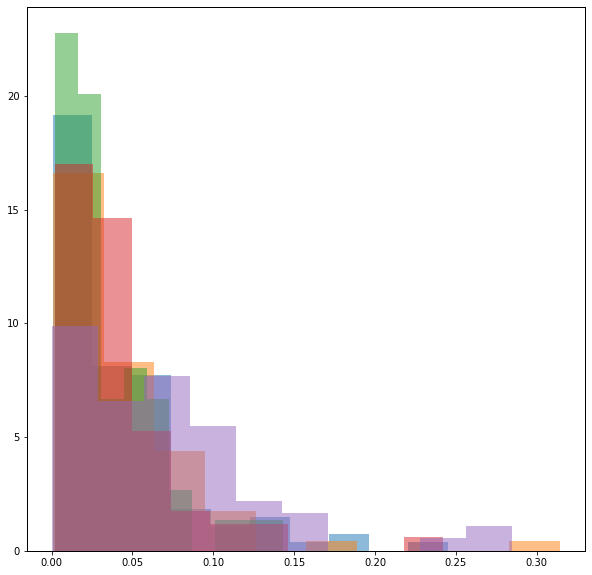

In [276]:
plt.hist(pval_chen_50_60.loc[[x for x in pval_chen_50_60.index if 'mock' not in x], 'C_score'], alpha=0.5, density=True)
plt.hist(pval_chen_60_70.loc[[x for x in pval_chen_60_70.index if 'mock' not in x], 'C_score'], alpha=0.5, density=True)
plt.hist(pval_chen_70_80.loc[[x for x in pval_chen_70_80.index if 'mock' not in x], 'C_score'], alpha=0.5, density=True)
plt.hist(pval_chen_80_90.loc[[x for x in pval_chen_80_90.index if 'mock' not in x], 'C_score'], alpha=0.5, density=True)
plt.hist(pval_chen_90_1000.loc[[x for x in pval_chen_90_1000.index if 'mock' not in x], 'C_score'], alpha=0.5, density=True)

In [286]:
exons_05_10 = chen_PSI.index[(np.abs(0.5 - chen_PSI.mean(axis = 1))>0.4) & (np.abs(0.5 - chen_PSI.mean(axis = 1))<=0.45)] 
exons_10_20 = chen_PSI.index[(np.abs(0.5 - chen_PSI.mean(axis = 1))>0.3) & (np.abs(0.5 - chen_PSI.mean(axis = 1))<=0.40)] 
exons_20_30 = chen_PSI.index[(np.abs(0.5 - chen_PSI.mean(axis = 1))>0.2) & (np.abs(0.5 - chen_PSI.mean(axis = 1))<=0.30)] 
exons_30_40 = chen_PSI.index[(np.abs(0.5 - chen_PSI.mean(axis = 1))>0.1) & (np.abs(0.5 - chen_PSI.mean(axis = 1))<=0.20)] 
exons_40_50 = chen_PSI.index[(np.abs(0.5 - chen_PSI.mean(axis = 1))<=0.1)] 

exons_obs_50_60 = chen_PSI.index[(chen_PSI.isna().mean(axis=1) <= 0.5) & (chen_PSI.isna().mean(axis=1) > 0.4)]
exons_obs_60_70 = chen_PSI.index[(chen_PSI.isna().mean(axis=1) <= 0.4) & (chen_PSI.isna().mean(axis=1) > 0.3)]
exons_obs_70_80 = chen_PSI.index[(chen_PSI.isna().mean(axis=1) <= 0.3) & (chen_PSI.isna().mean(axis=1) > 0.2)]
exons_obs_80_90 = chen_PSI.index[(chen_PSI.isna().mean(axis=1) <= 0.2) & (chen_PSI.isna().mean(axis=1) > 0.1)]
exons_obs_90_100 = chen_PSI.index[(chen_PSI.isna().mean(axis=1) <= 0.1)]

list1 = [exons_05_10, exons_10_20, exons_20_30, exons_30_40, exons_40_50]
list2 = [exons_obs_50_60, exons_obs_60_70, exons_obs_70_80, exons_obs_80_90, exons_obs_90_100]


In [287]:
from itertools import permutations

In [289]:
all_combinations = []
list1_permutations = permutations(list1, len(list2))
for each_permutation in list1_permutations:
    zipped = zip(each_permutation, list2)
    all_combinations.append(list(zipped))

# print(all_combinations)

In [312]:
pval_list = []

for lista_1 in list1:
    for lista_2 in list2:
        combination = lista_1 & lista_2
        if len(combination) > 0:
            pval_list.append(run_autocorrelation_test(chen_PSI.loc[combination], 
                                           chen_mrna_counts, 
                             chen_pca_clust, Ws=W_chen, cluster_frac = 0.5, mock_rounds = 100, min_obs = 0.5, 
                         psi_int = 0.05, plot_weights=True), norm_PSI = chen_norm_PSI)

HBox(children=(IntProgress(value=0, max=93), HTML(value='')))

HBox(children=(IntProgress(value=0, max=4069), HTML(value='')))

HBox(children=(IntProgress(value=0, max=86), HTML(value='')))

HBox(children=(IntProgress(value=0, max=3258), HTML(value='')))

HBox(children=(IntProgress(value=0, max=89), HTML(value='')))

HBox(children=(IntProgress(value=0, max=3967), HTML(value='')))

HBox(children=(IntProgress(value=0, max=88), HTML(value='')))

HBox(children=(IntProgress(value=0, max=4348), HTML(value='')))

HBox(children=(IntProgress(value=0, max=96), HTML(value='')))

HBox(children=(IntProgress(value=0, max=4524), HTML(value='')))

HBox(children=(IntProgress(value=0, max=86), HTML(value='')))

HBox(children=(IntProgress(value=0, max=4027), HTML(value='')))

HBox(children=(IntProgress(value=0, max=62), HTML(value='')))

HBox(children=(IntProgress(value=0, max=3314), HTML(value='')))

HBox(children=(IntProgress(value=0, max=54), HTML(value='')))

HBox(children=(IntProgress(value=0, max=2780), HTML(value='')))

HBox(children=(IntProgress(value=0, max=36), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1707), HTML(value='')))

HBox(children=(IntProgress(value=0, max=57), HTML(value='')))

HBox(children=(IntProgress(value=0, max=2771), HTML(value='')))

HBox(children=(IntProgress(value=0, max=60), HTML(value='')))

HBox(children=(IntProgress(value=0, max=3930), HTML(value='')))

HBox(children=(IntProgress(value=0, max=32), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1635), HTML(value='')))

HBox(children=(IntProgress(value=0, max=30), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1586), HTML(value='')))

HBox(children=(IntProgress(value=0, max=34), HTML(value='')))

HBox(children=(IntProgress(value=0, max=2052), HTML(value='')))

HBox(children=(IntProgress(value=0, max=30), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1496), HTML(value='')))

HBox(children=(IntProgress(value=0, max=40), HTML(value='')))

HBox(children=(IntProgress(value=0, max=3179), HTML(value='')))

HBox(children=(IntProgress(value=0, max=25), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1939), HTML(value='')))

HBox(children=(IntProgress(value=0, max=21), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1549), HTML(value='')))

HBox(children=(IntProgress(value=0, max=25), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1601), HTML(value='')))

HBox(children=(IntProgress(value=0, max=21), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1485), HTML(value='')))

HBox(children=(IntProgress(value=0, max=26), HTML(value='')))

HBox(children=(IntProgress(value=0, max=2059), HTML(value='')))

HBox(children=(IntProgress(value=0, max=35), HTML(value='')))

HBox(children=(IntProgress(value=0, max=2728), HTML(value='')))

HBox(children=(IntProgress(value=0, max=16), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1208), HTML(value='')))

HBox(children=(IntProgress(value=0, max=17), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1239), HTML(value='')))

HBox(children=(IntProgress(value=0, max=17), HTML(value='')))

HBox(children=(IntProgress(value=0, max=874), HTML(value='')))

In [322]:
pval_list_combined = pd.DataFrame()
for pval_l in pval_list:
    pval_list_combined = pval_list_combined.append(pval_l.loc[[x for x in pval_l.index if 'mock' not in x]])

In [329]:
i = 0
for lista in pval_list:
    i += lista.shape[0]

(array([11.34068815,  1.30854094,  1.41758602,  0.54522539,  0.21809016,
         0.32713524,  0.54522539,  0.10904508,  0.32713524,  0.43618031,
         0.21809016,  0.21809016,  0.        ,  0.43618031,  0.43618031,
         0.43618031,  0.10904508,  0.43618031,  0.54522539,  0.87236063]),
 array([2.20994475e-04, 4.95248619e-02, 9.88287293e-02, 1.48132597e-01,
        1.97436464e-01, 2.46740331e-01, 2.96044199e-01, 3.45348066e-01,
        3.94651934e-01, 4.43955801e-01, 4.93259669e-01, 5.42563536e-01,
        5.91867403e-01, 6.41171271e-01, 6.90475138e-01, 7.39779006e-01,
        7.89082873e-01, 8.38386740e-01, 8.87690608e-01, 9.36994475e-01,
        9.86298343e-01]),
 <a list of 20 Patch objects>)

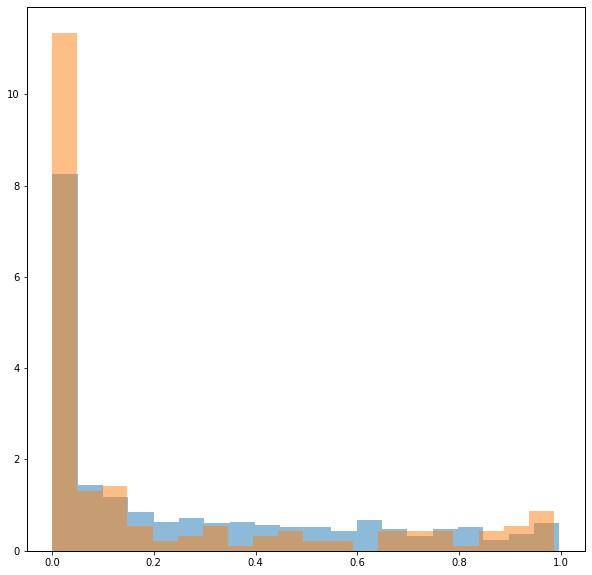

In [337]:
selected_mrna = [x for x in chen_filtered_lax[0].index[chen_filtered_lax[0].isna().mean(axis=1) <= 0.5] if x in pval_list_combined.index]
plt.hist(pval_list_combined.loc[[x for x in pval_list_combined.index if x not in selected_mrna], 'pvals'], density = True, alpha=0.5, bins=20)
plt.hist(pval_list_combined.loc[selected_mrna, 'pvals'], density = True, alpha=0.5, bins=20)

(array([7.3108317 , 2.49109821, 1.08308618, 1.29970341, 0.81231463,
        0.70400602, 0.70400602, 0.5956974 , 0.27077154, 0.5956974 ,
        0.86646894, 0.54154309, 0.37908016, 0.37908016, 0.64985171,
        0.27077154, 0.10830862, 0.27077154, 0.16246293, 0.54154309]),
 array([3.08546745e-04, 5.02159827e-02, 1.00123419e-01, 1.50030855e-01,
        1.99938291e-01, 2.49845727e-01, 2.99753163e-01, 3.49660599e-01,
        3.99568035e-01, 4.49475471e-01, 4.99382907e-01, 5.49290342e-01,
        5.99197778e-01, 6.49105214e-01, 6.99012650e-01, 7.48920086e-01,
        7.98827522e-01, 8.48734958e-01, 8.98642394e-01, 9.48549830e-01,
        9.98457266e-01]),
 <a list of 20 Patch objects>)

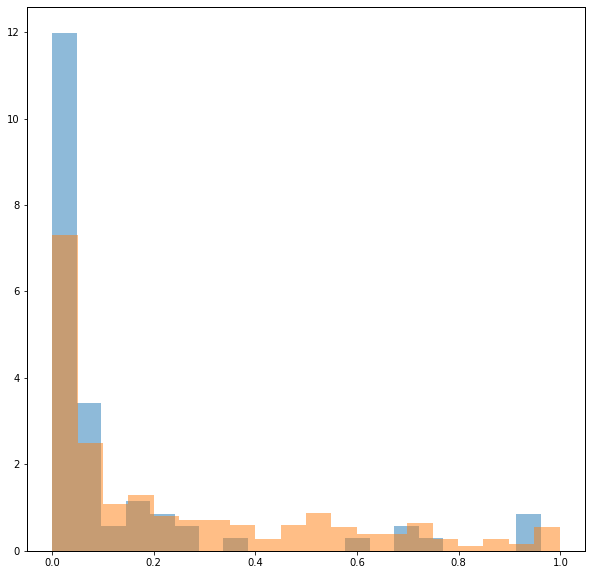

In [341]:
selected_mrna = [x for x in chen_filtered_lax[0].index[chen_filtered_lax[0].isna().mean(axis=1) <= 0.5] if x in pval_chen.index]

plt.hist(pval_chen.loc[selected_mrna, 'pvals'], density=True, alpha=0.5, bins=20)
plt.hist(pval_chen.loc[[x for x in pval_chen.index if 'mock' not in x], 'pvals'], density=True, alpha=0.5, bins=20)

In [344]:
pval_chen.shape

(3240, 2)

In [346]:
selected_mrna = [x for x in chen_filtered_lax[0].index[chen_filtered_lax[0].isna().mean(axis=1) <= 0.5] if x in pval_list_combined.index]

pval_list_combined.loc[selected_mrna, 'pvals'].shape

(186,)

In [377]:
Rrpn2_c = run_autocorrelation_test(pd.DataFrame(chen_PSI.loc['Rpn2_1']).T, 
                                           chen_mrna_counts, 
                             chen_pca_clust, Ws=W_chen, cluster_frac = 0.5, mock_rounds = 100, min_obs = 0.5, 
                         psi_int = 0.05, plot_weights=True, norm_PSI = pd.DataFrame(chen_norm_PSI.loc['Rpn2_1']).T)

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=70), HTML(value='')))

In [355]:
chen_PSI.loc['Rpn2_1'].mean()

0.07545864610388993

In [481]:
def run_autocorrelation_test_silent(PSI_tab, mrna_counts, 
                             pca, Ws, norm_PSI, mock_rounds = 100):
    total_cells = len(PSI_tab.columns)

    test_exons = PSI_tab.index

    exon_list = []
    C_scores = []
    
    
    
    
#     print(test_exons)
    for exon in test_exons:
        exon_df = norm_PSI.loc[exon] # to make things faster
        exon_score = get_C(exon_df, Ws)
        mock_exons_tested = 0
        if exon_score >= 0:
            C_scores.append(exon_score)
            exon_list.append(exon)

            
            while mock_exons_tested < mock_rounds:
                
#                 i = mock_exons_tested + 1
#             for i in range(mock_rounds):
                scramble_cells = r.choice(norm_PSI.columns, total_cells, replace=False)
                mock_PSI = pd.DataFrame(norm_PSI.loc[exon, scramble_cells]).T
                mock_PSI.columns = PSI_tab.columns
                mock_df = mock_PSI.loc[exon]
#                 tiempo = t.time()
                mock_score = get_C(mock_df, Ws)
#                 print(t.time()-tiempo)
                if mock_score >= 0:
                    C_scores.append(mock_score)
                    exon_list.append('mock_'+exon+'_'+str(mock_exons_tested))
                    mock_exons_tested +=1
                    
        else:
            return ''
                    


    pvals = pd.DataFrame()
    pvals['C_score'] = C_scores
    pvals.index = exon_list
    
    
    n = len(pvals.C_score)
    pval_list = []

    for exon in pvals.index:
        C = pvals.loc[exon, 'C_score']
        x = np.sum(pvals.C_score > C)
        pvalue = (x+1)/(n+1)
        pval_list.append(pvalue)

    pvals['pvals'] = pval_list
    
    
    return pvals

def run_autocorrelation_test_exon_list(PSI_tab, mrna_counts, exon_list,
                             pca, Ws, norm_PSI, mock_rounds = 100):
    
    pval_dataframe = pd.DataFrame()
    
    for exon in tqdm(exon_list):
        exon_pvals = run_autocorrelation_test_silent(pd.DataFrame(PSI_tab.loc[exon]).T, 
                                           mrna_counts, 
                             pca, Ws=Ws, mock_rounds = mock_rounds, 
                         norm_PSI = pd.DataFrame(norm_PSI.loc[exon]).T)
#         print(exon_pvals)
            
        if len(exon_pvals) > 0:
            pval_dataframe = pval_dataframe.append(pd.DataFrame(exon_pvals.loc[exon]).T)
        
    return pval_dataframe
    
    
 

In [565]:
int_genes, int_exons = spu.get_int_events(chen_PSI, chen_mrna_counts, 0.05)
observed_exons = chen_PSI.index[chen_PSI.isna().mean(axis=1) <= (1-0.5)]
test_exons = [x for x in observed_exons if x in int_exons]

chen_exonwise_pvals = run_autocorrelation_test_exon_list(chen_PSI, chen_mrna_counts, test_exons,
                             chen_pca_clust, W_chen, chen_norm_PSI, mock_rounds = 200)

chen_exonwise_pvals.to_csv('chen_exonwise_pvals.tab', sep='\t', header=True, index=True)

HBox(children=(IntProgress(value=0, max=1176), HTML(value='')))

In [566]:
# W_song = get_distance_matrix(song_pca_clust, k=101)
# song_norm_PSI = get_signature_matrix(song_PSI)
int_genes, int_exons = spu.get_int_events(song_PSI, song_mrna_counts, 0.05)
observed_exons = song_PSI.index[song_PSI.isna().mean(axis=1) <= (1-0.5)]
test_exons = [x for x in observed_exons if x in int_exons]

song_exonwise_pvals = run_autocorrelation_test_exon_list(song_PSI, song_mrna_counts, test_exons,
                             song_pca_clust, W_song, song_norm_PSI, mock_rounds = 200)

song_exonwise_pvals.to_csv('song_exonwise_pvals.tab', sep='\t', header=True, index=True)

HBox(children=(IntProgress(value=0, max=908), HTML(value='')))

In [567]:
# W_trapnell = get_distance_matrix(trapnell_pca_clust, k=115)

# trapnell_norm_PSI = get_signature_matrix(trapnell_PSI)

int_genes, int_exons = spu.get_int_events(trapnell_PSI, trapnell_mrna_counts, 0.05)
observed_exons = trapnell_PSI.index[trapnell_PSI.isna().mean(axis=1) <= (1-0.5)]
test_exons = [x for x in observed_exons if x in int_exons]

trapnell_exonwise_pvals = run_autocorrelation_test_exon_list(trapnell_PSI, trapnell_mrna_counts, test_exons,
                             trapnell_pca_clust, W_trapnell, trapnell_norm_PSI, mock_rounds = 200)

trapnell_exonwise_pvals.to_csv('trapnell_exonwise_pvals.tab', sep='\t', header=True, index=True)

HBox(children=(IntProgress(value=0, max=826), HTML(value='')))

In [568]:
# lescroart_norm_PSI = get_signature_matrix(lescroart_PSI)

# W_lescroart = get_distance_matrix(lescroart_pca_clust, k=256)
int_genes, int_exons = spu.get_int_events(lescroart_PSI, lescroart_mrna_counts, 0.05)
observed_exons = lescroart_PSI.index[lescroart_PSI.isna().mean(axis=1) <= (1-0.5)]
test_exons = [x for x in observed_exons if x in int_exons]

lescroart_exonwise_pvals = run_autocorrelation_test_exon_list(lescroart_PSI, lescroart_mrna_counts, test_exons,
                             lescroart_pca_clust, W_lescroart, lescroart_norm_PSI, mock_rounds = 200)

lescroart_exonwise_pvals.to_csv('lescroart_exonwise_pvals.tab', sep='\t', header=True, index=True)

HBox(children=(IntProgress(value=0, max=941), HTML(value='')))

In [14]:
chen_exonwise_pvals = pd.read_csv('chen_exonwise_pvals.tab', sep='\t', index_col=0)
lescroart_exonwise_pvals = pd.read_csv('lescroart_exonwise_pvals.tab', sep='\t', index_col=0)
trapnell_exonwise_pvals = pd.read_csv('trapnell_exonwise_pvals.tab', sep='\t', index_col=0)
song_exonwise_pvals = pd.read_csv('song_exonwise_pvals.tab', sep='\t', index_col=0)

mRNA: 192
read: 63
mRNA: 103
read: 55
mRNA: 66
read: 205
mRNA: 91
read: 468


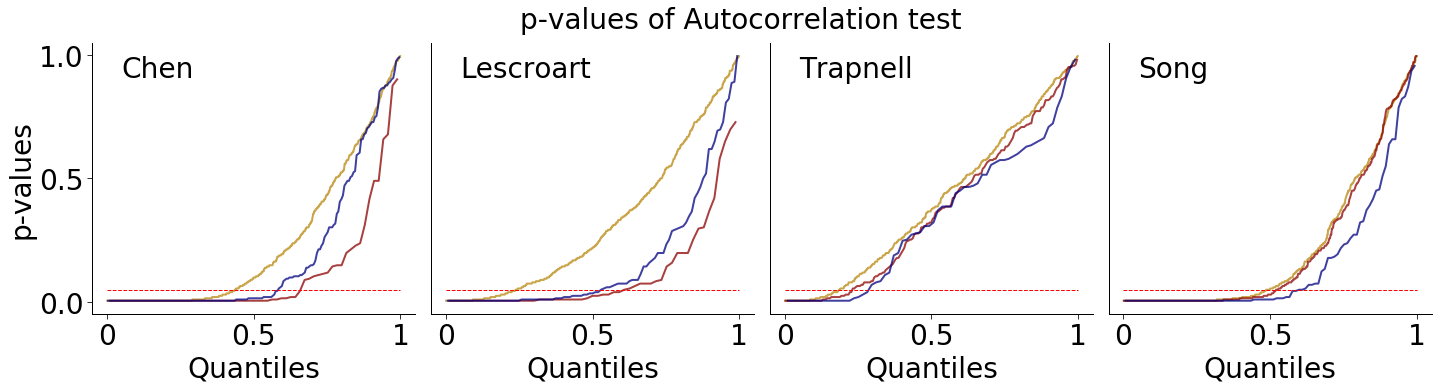

In [18]:
def plot_pvalues(ax, pval_df, filtered_PSI, rfiltered_PSI, min_obs = 0.5):
    
    selected_mrna = [x for x in filtered_PSI.index[filtered_PSI.isna().mean(axis=1) <= min_obs] if x in pval_df.index]
    selected_read = [x for x in rfiltered_PSI.index[rfiltered_PSI.isna().mean(axis=1) <= min_obs] if x in pval_df.index]

    print('mRNA: ' + str(len(selected_mrna)))
    print('read: ' + str(len(selected_read)))
    
    current_palette = sns.color_palette('dark')
    
    pplot_1 = probplot(pval_df.pvals, dist='uniform')[0]
    pplot_2 = probplot(pval_df.loc[selected_read, 'pvals'], dist='uniform')[0]
#     pplot_3 = probplot(pvals.loc[selected_mrna_only, 'pvals'], dist='uniform')[0]
    pplot_4 = probplot(pval_df.loc[selected_mrna, 'pvals'], dist='uniform')[0]
    
    ax.plot(pplot_1[0], pplot_1[1], alpha = 0.75, c=current_palette[4], label='all exons', linewidth=2)
    ax.plot(pplot_2[0], pplot_2[1], alpha = 0.75, c='darkred', label='read filter', linewidth=2)
#     ax.plot(pplot_3[0], pplot_3[1], alpha = 0.75, c='forestgreen', label='mRNA only filter', linewidth=2)
    ax.plot(pplot_4[0], pplot_4[1], alpha = 0.75, c='navy', label='combined filter', linewidth=2)
    ax.plot([0, 1], [0.05, 0.05], 'r--', linewidth=1)
    ax.set_xlabel('Quantiles', fontsize=28)
    ax.tick_params(labelsize=28, length=5)
    
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    
    
    ax.set_xticks([0, 0.5, 1])
    ax.set_xticklabels(['0', '0.5', '1'])
    
    ax.tick_params(labelsize=28, length=5)
    
    
    
figsize(24, 5)
fig = plt.figure()

fig.suptitle('p-values of Autocorrelation test', fontsize=28)

gs = GridSpec(1,4)
gs.update(wspace=0.05, hspace=1.05)

ax_1 = fig.add_subplot(gs[0,0])
ax_2 = fig.add_subplot(gs[0,1])
ax_3 = fig.add_subplot(gs[0,2])
ax_4 = fig.add_subplot(gs[0,3])

ax_1.set_ylim((-0.05,1.05))
ax_2.set_ylim((-0.05,1.05))
ax_3.set_ylim((-0.05,1.05))
ax_4.set_ylim((-0.05,1.05))

plot_pvalues(ax_1, chen_exonwise_pvals, chen_filtered_lax[0], chen_filtered_lax_reads[0])
plot_pvalues(ax_2, lescroart_exonwise_pvals, lescroart_filtered_lax[0], lescroart_filtered_lax_reads[0])
plot_pvalues(ax_3, trapnell_exonwise_pvals, trapnell_filtered_lax[0], trapnell_filtered_lax_reads[0])
plot_pvalues(ax_4, song_exonwise_pvals, song_filtered_lax[0], song_filtered_lax_reads[0])

plt.setp(ax_2.get_yticklabels(), visible=False)
plt.setp(ax_3.get_yticklabels(), visible=False)
plt.setp(ax_4.get_yticklabels(), visible=False)
ax_2.yaxis.set_ticks_position('none')
ax_3.yaxis.set_ticks_position('none')
ax_4.yaxis.set_ticks_position('none')


ax_1.text(0.05, 1, 'Chen', fontsize=28, verticalalignment='top')
ax_2.text(0.05, 1, 'Lescroart', fontsize=28, verticalalignment='top')
ax_3.text(0.05, 1, 'Trapnell', fontsize=28, verticalalignment='top')
ax_4.text(0.05, 1, 'Song', fontsize=28, verticalalignment='top')

# ax_3.set_xticks([0, 0.5, 1], ['0', '0.5', '1'])
            
ax_1.set_ylabel('p-values', fontsize = 28)
# ax_4.legend(loc='center left', frameon=False, fontsize=14)

# plt.savefig('plots_review/figure3/autocorrelation/pvalues_3sets.svg', bbox_inches='tight', transparent=True)
# plt.savefig('plots_review/figure3/autocorrelation/pvalues_3sets.pdf', bbox_inches='tight', transparent=True)
# plt.savefig('plots_review/figure3/autocorrelation/pvalues_3sets.png', dpi=300, bbox_inches='tight', transparent=True)

plt.show()




In [35]:
def get_fold_enrichment(test_data, pval):
    
    pvals, selected_mrna, selected_read = test_data
    M = len(pvals)
    n = np.sum((pvals <= pval).pvals)
    
    N_mrna = len(selected_mrna)
    k_mrna = np.sum((pvals.loc[selected_mrna] <= pval).pvals)
    
#     N_mrna_only = len(selected_mrna_only)
#     k_mrna_only = np.sum((pvals.loc[selected_mrna_only] <= pval).pvals)
    
    N_read = len(selected_read)
    k_read = np.sum((pvals.loc[selected_read] <= pval).pvals)
    
    mrna_enrichment = (k_mrna*M)/(n*N_mrna)
#     mrna_only_enrichment = (k_mrna_only*M)/(n*N_mrna_only)
    read_enrichment = (k_read*M)/(n*N_read)
    
    return read_enrichment, mrna_enrichment, M, n, N_read, k_read, N_mrna, k_mrna 
    
def get_enrichment(test_data):
    p_limits = 10**(-np.arange(-np.log10(0.1), -np.log10(0.005)+0.005, 0.005))
    read_enrichment = []
#     mrna_only_enrichment = []
    mrna_enrichment = []
    
    read_pvals = []
#     mrna_only_pvals = []
    mrna_pvals = []
    
    for x in p_limits:
        enrich = get_fold_enrichment(test_data, x)
        read_enrichment.append(enrich[0])
#         mrna_only_enrichment.append(enrich[1])
        mrna_enrichment.append(enrich[1])
        
        read_pvals.append(hyper_test(enrich[2], enrich[3], enrich[4], enrich[5])[1])
#         mrna_only_pvals.append(hyper_test(enrich[3], enrich[4], enrich[7], enrich[8])[1])
        mrna_pvals.append(hyper_test(enrich[2], enrich[3], enrich[6], enrich[7])[1])
        
#     read_padj = multipletests(read_pvals, method='fdr_bh')[1]
#     mrna_only_padj = multipletests(mrna_only_pvals, method='fdr_bh')[1]
#     mrna_padj = multipletests(mrna_pvals, method='fdr_bh')[1]

    corrected = multipletests(read_pvals + mrna_pvals, method='fdr_bh')[1]
    read_padj = corrected[:len(p_limits)]
#     mrna_only_padj = corrected[len(p_limits):2*len(p_limits)]
    mrna_padj = corrected[len(p_limits):]
        
    return read_enrichment, mrna_enrichment, read_padj, mrna_padj

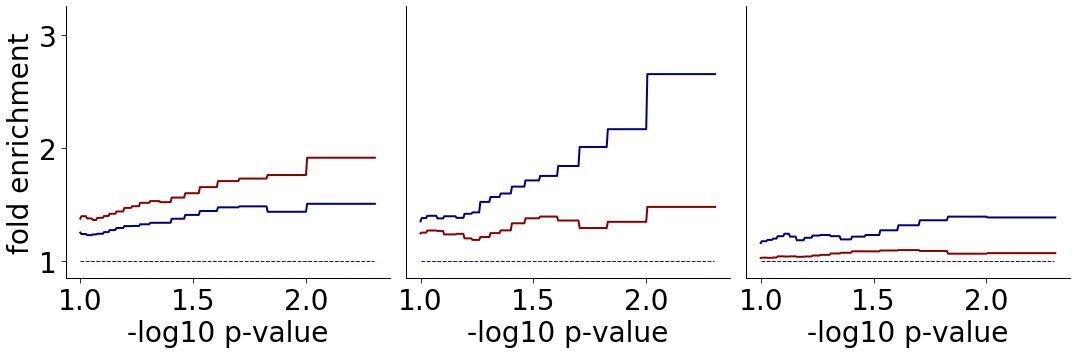

In [44]:
# chen_selected_mrna = [x for x in chen_filtered_lax[0].index[chen_filtered_lax[0].isna().mean(axis=1) <= 0.5] if x in chen_exonwise_pvals.index]
# chen_selected_read = [x for x in chen_filtered_lax_reads[0].index[chen_filtered_lax_reads[0].isna().mean(axis=1) <= 0.5] if x in chen_exonwise_pvals.index]
# chen_data = (chen_exonwise_pvals, chen_selected_mrna, chen_selected_read)
# lescroart_selected_mrna = [x for x in lescroart_filtered_lax[0].index[lescroart_filtered_lax[0].isna().mean(axis=1) <= 0.5] if x in lescroart_exonwise_pvals.index]
# lescroart_selected_read = [x for x in lescroart_filtered_lax_reads[0].index[lescroart_filtered_lax_reads[0].isna().mean(axis=1) <= 0.5] if x in lescroart_exonwise_pvals.index]
# lescroart_data = (lescroart_exonwise_pvals, lescroart_selected_mrna, lescroart_selected_read)
# trapnell_selected_mrna = [x for x in trapnell_filtered_lax[0].index[trapnell_filtered_lax[0].isna().mean(axis=1) <= 0.5] if x in trapnell_exonwise_pvals.index]
# trapnell_selected_read = [x for x in trapnell_filtered_lax_reads[0].index[trapnell_filtered_lax_reads[0].isna().mean(axis=1) <= 0.5] if x in trapnell_exonwise_pvals.index]
# trapnell_data = (trapnell_exonwise_pvals, trapnell_selected_mrna, trapnell_selected_read)
# song_selected_mrna = [x for x in song_filtered_lax[0].index[song_filtered_lax[0].isna().mean(axis=1) <= 0.5] if x in song_exonwise_pvals.index]
# song_selected_read = [x for x in song_filtered_lax_reads[0].index[song_filtered_lax_reads[0].isna().mean(axis=1) <= 0.5] if x in song_exonwise_pvals.index]
# song_data = (song_exonwise_pvals, song_selected_mrna, song_selected_read)



chen_enrichment = get_enrichment(chen_data)
# lescroart_enrichment = get_enrichment(lescroart_data_out)
trapnell_enrichment = get_enrichment(trapnell_data)
song_enrichment = get_enrichment(song_data)


def plot_filter_lines(ax, read, mrna):
        
    current_palette = sns.color_palette('dark')
#     10**(-np.arange(-np.log10(0.1), -np.log10(0.005)+0.001, 0.001))
    ax.plot((np.arange(-np.log10(0.1), -np.log10(0.005)+0.005, 0.005)), read, c='darkred', 
            label='read filter', linewidth=2)
#     ax.plot((np.arange(-np.log10(0.1), -np.log10(0.00001)+0.05, 0.05)), mrna_only, c='forestgreen', 
#             label='mrna only filter', linewidth=2)
    ax.plot((np.arange(-np.log10(0.1), -np.log10(0.005)+0.005, 0.005)), mrna, c='navy', 
            label='combined filter', linewidth=2)
    
    
    ax.set_xlabel('-log10 p-value', fontsize=28)
    ax.tick_params(labelsize=28, length=5)
    
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    
    
#     ax.set_xticks([1, 2, 3, 4, 5])
#     ax.set_xticklabels(['1', '2', '3', '4', '5'])
    
    ax.tick_params(labelsize=28, length=5)
    
    
figsize(18, 5)

fig = plt.figure()

# fig.suptitle('', fontsize=28)

gs = GridSpec(1,3)
gs.update(wspace=0.05, hspace=1.05)

ax_1 = fig.add_subplot(gs[0,0])
ax_2 = fig.add_subplot(gs[0,1])
ax_3 = fig.add_subplot(gs[0,2])
# ax_4 = fig.add_subplot(gs[0,3])

ax_1.set_ylim((0.85,3.25))
ax_2.set_ylim((0.85,3.25))
ax_3.set_ylim((0.85,3.25))
# ax_4.set_ylim((0.85,3.25))

plot_filter_lines(ax_1, chen_enrichment[0], chen_enrichment[1])
# plot_filter_lines(ax_2, lescroart_enrichment[0], lescroart_enrichment[1], lescroart_enrichment[2])
plot_filter_lines(ax_2, trapnell_enrichment[0], trapnell_enrichment[1])
plot_filter_lines(ax_3, song_enrichment[0], song_enrichment[1])

plt.setp(ax_2.get_yticklabels(), visible=False)
plt.setp(ax_3.get_yticklabels(), visible=False)
# plt.setp(ax_4.get_yticklabels(), visible=False)
ax_2.yaxis.set_ticks_position('none')
ax_3.yaxis.set_ticks_position('none')
# ax_4.yaxis.set_ticks_position('none')


# ax_1.text(0.05, 1, 'Chen', fontsize=28, verticalalignment='top')
# ax_2.text(0.05, 1, 'Lescroart', fontsize=28, verticalalignment='top')
# ax_3.text(0.05, 1, 'Trapnell', fontsize=28, verticalalignment='top')
# ax_4.text(0.05, 1, 'Song', fontsize=28, verticalalignment='top')

ax_1.plot([1, -log10(0.005)], [1, 1], 'b--', linewidth=1)
ax_2.plot([1, -log10(0.005)], [1, 1], 'b--', linewidth=1)
ax_3.plot([1, -log10(0.005)], [1, 1], 'b--', linewidth=1)
# ax_4.plot([1, 5], [1, 1], 'b--', linewidth=1)

# ax_3.set_xticks([0, 0.5, 1], ['0', '0.5', '1'])
            
ax_1.set_ylabel('fold enrichment', fontsize = 28)
# ax_4.legend(loc='center left', frameon=False, fontsize=14)

plt.savefig('plots_review/figure3/autocorrelation/enrichment_3sets.svg', bbox_inches='tight', transparent=True)
plt.savefig('plots_review/figure3/autocorrelation/enrichment_3sets.pdf', bbox_inches='tight', transparent=True)
plt.savefig('plots_review/figure3/autocorrelation/enrichment_3sets.png', dpi=300, bbox_inches='tight', transparent=True)

plt.show()




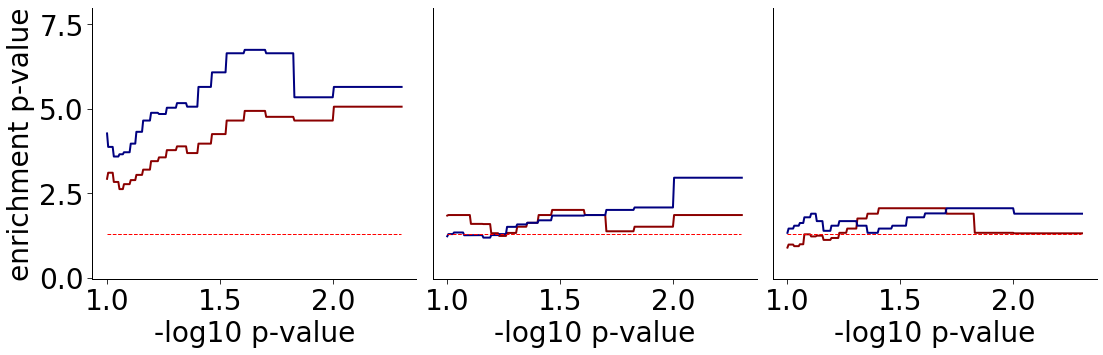

In [43]:
figsize(18, 5)

fig = plt.figure()

# fig.suptitle('', fontsize=28)

gs = GridSpec(1,3)
gs.update(wspace=0.05, hspace=1.05)

ax_1 = fig.add_subplot(gs[0,0])
ax_2 = fig.add_subplot(gs[0,1])
ax_3 = fig.add_subplot(gs[0,2])
# ax_4 = fig.add_subplot(gs[0,3])

ax_1.set_ylim((-0.05,8))
ax_2.set_ylim((-0.05, 8))
ax_3.set_ylim((-0.05, 8))
# ax_4.set_ylim((-0.05,25))

plot_filter_lines(ax_1, -np.log10(chen_enrichment[2]), -np.log10(chen_enrichment[3]))
plot_filter_lines(ax_2, -np.log10(trapnell_enrichment[2]), -np.log10(trapnell_enrichment[3]))
plot_filter_lines(ax_3, -np.log10(song_enrichment[2]), -np.log10(song_enrichment[3]))

ax_1.plot([1, -log10(0.005)], -np.log10([0.05, 0.05]), 'r--', linewidth=1)
ax_2.plot([1, -log10(0.005)], -np.log10([0.05, 0.05]), 'r--', linewidth=1)
ax_3.plot([1, -log10(0.005)], -np.log10([0.05, 0.05]), 'r--', linewidth=1)

plt.setp(ax_2.get_yticklabels(), visible=False)
plt.setp(ax_3.get_yticklabels(), visible=False)
ax_2.yaxis.set_ticks_position('none')
ax_3.yaxis.set_ticks_position('none')
            
ax_1.set_ylabel('enrichment p-value', fontsize = 28)

plt.savefig('plots_review/figure3/autocorrelation/enrichment_pvals_3sets.svg', bbox_inches='tight', transparent=True)
plt.savefig('plots_review/figure3/autocorrelation/enrichment_pvals_3sets.pdf', bbox_inches='tight', transparent=True)
plt.savefig('plots_review/figure3/autocorrelation/enrichment_pvals_3sets.png', dpi=300, bbox_inches='tight', transparent=True)

plt.show()




In [50]:
def plot_curves(ax, test_data, which_curve = 0, p_max = 0.1, p_min = 0.00001, steps = 0.05):
    
    names = ['Recall', 'Precision', 'Specificity', 'F1 score', 'Recall/Specificity', 
             'LR+', 'LR-', 'Diagnostic Odds Ratio', 'Accuracy', 'Balanced Accuracy']
    
    name = names[which_curve]    
    pvals, selected_mrna, selected_read = test_data
    p_limits = 10**(-np.arange(-np.log10(p_max), -np.log10(p_min)+steps, steps))
#     print(len(selected_mrna))
    summary_mrna = summary_curves(pvals, selected_mrna, p_limits, 1)[which_curve]
    summary_read = summary_curves(pvals, selected_read, p_limits, 1)[which_curve]
    
    
    ax.plot(-np.log10(p_limits), summary_read, c='darkred', label='read filter', linewidth=2)
    ax.plot(-np.log10(p_limits), summary_mrna, c='navy', label='mRNA filter', linewidth=2)
    ax.set_xlabel('-log10 p-value', fontsize=28)
    ax.tick_params(labelsize=28, length=5)
    
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    
    ax.tick_params(labelsize=28, length=5)

    
def plot_dset_curves(chen_data_out, trapnell_data_out, song_data_out, 
                     which_curve = 0, p_max = 0.1, p_min = 0.005, steps = 0.005, ylims=(0, 1)):
    
    names = ['Recall', 'Precision', 'Specificity', 'F1 score', 'Recall/Specificity', 
             'LR+', 'LR-', 'Diagnostic Odds Ratio', 'Accuracy', 'Balanced Accuracy']
    
    figsize(18, 5)
    fig = plt.figure()

    # fig.suptitle('p-values of anova test', fontsize=28)

    gs = GridSpec(1,3)
    gs.update(wspace=0.05, hspace=1.05)

    ax_1 = fig.add_subplot(gs[0,0])
    ax_2 = fig.add_subplot(gs[0,1])
    ax_3 = fig.add_subplot(gs[0,2])

    ax_1.set_ylim(ylims)
    ax_2.set_ylim(ylims)
    ax_3.set_ylim(ylims)

    plot_curves(ax_1, chen_data, which_curve, p_max, p_min, steps)
    plot_curves(ax_2, trapnell_data, which_curve, p_max, p_min, steps)
    plot_curves(ax_3, song_data, which_curve, p_max, p_min, steps)

    # plt.setp(ax_2.get_yticklabels(), visible=False)
    # plt.setp(ax_3.get_yticklabels(), visible=False)
    # plt.setp(ax_4.get_yticklabels(), visible=False)
    # ax_2.yaxis.set_ticks_position('none')
    # ax_3.yaxis.set_ticks_position('none')
    # ax_4.yaxis.set_ticks_position('none')


#     ax_1.text(2.5, 0.75, 'Chen', fontsize=28, verticalalignment='top')
#     ax_2.text(2.5, 0.75, 'Trapnell', fontsize=28, verticalalignment='top')
#     ax_3.text(2.5, 0.75, 'Song', fontsize=28, verticalalignment='top')

    xticks = range(int(-np.log10(p_max)), int(-np.log10(p_min))+1)

    ax_1.set_xticks(xticks)
    ax_1.set_xticklabels([str(i) for i in xticks])
    ax_2.set_xticks(xticks)
    ax_2.set_xticklabels([str(i) for i in xticks])
    ax_3.set_xticks(xticks)
    ax_3.set_xticklabels([str(i) for i in xticks])

    ax_1.set_ylabel(names[which_curve], fontsize = 28)

    plt.setp(ax_2.get_yticklabels(), visible=False)
    plt.setp(ax_3.get_yticklabels(), visible=False)
    ax_2.yaxis.set_ticks_position('none')
    ax_3.yaxis.set_ticks_position('none')
    
    plot_name = '_'.join(names[which_curve].split()).lower()

    plt.savefig('plots_review/figure3/autocorrelation/' + plot_name + '.svg', bbox_inches='tight', transparent=True)
    plt.savefig('plots_review/figure3/autocorrelation/' + plot_name + '.pdf', bbox_inches='tight', transparent=True)
    plt.savefig('plots_review/figure3/autocorrelation/' + plot_name + '.png', dpi=300, bbox_inches='tight', transparent=True)

    plt.show()


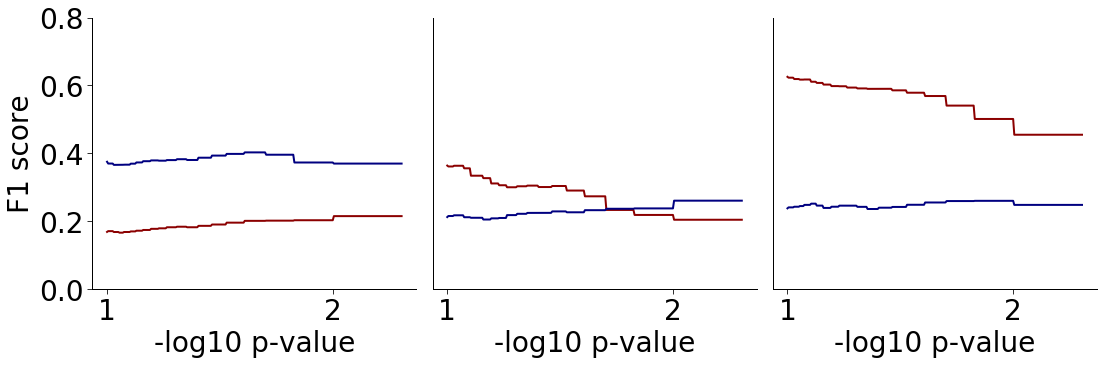

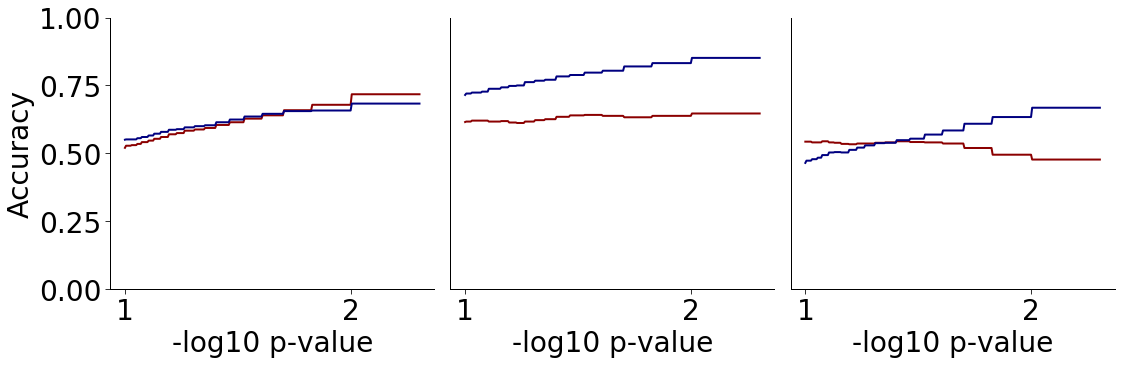

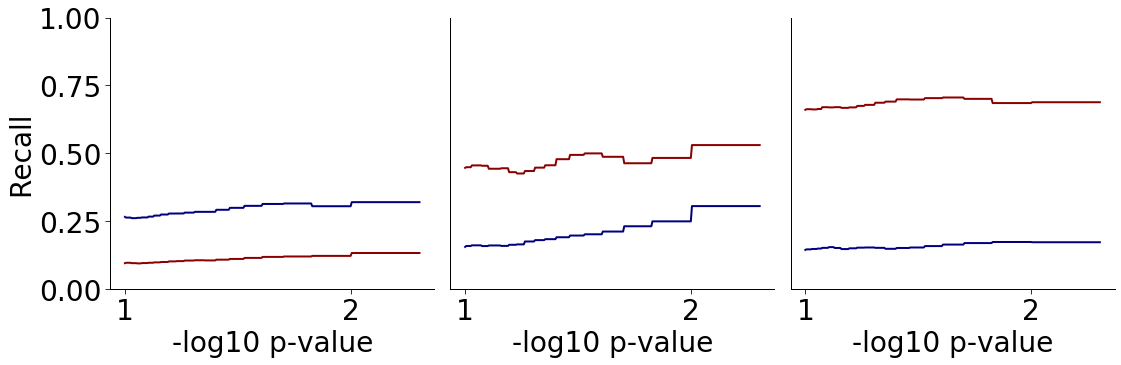

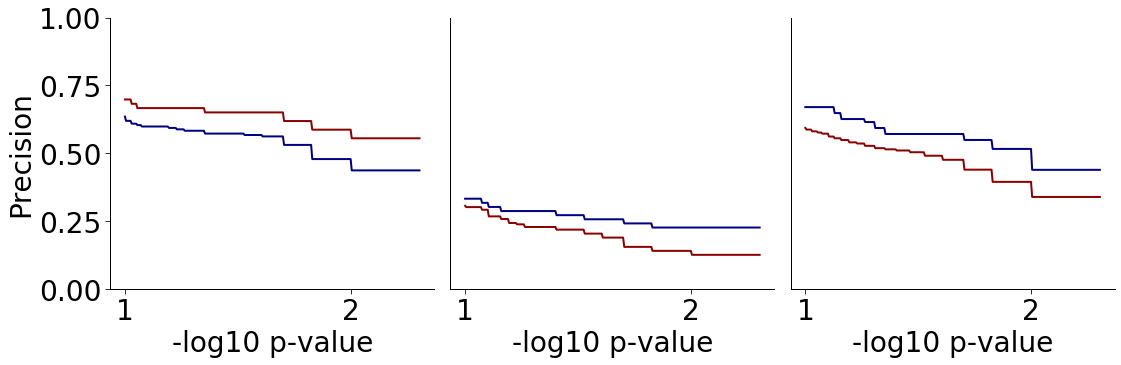

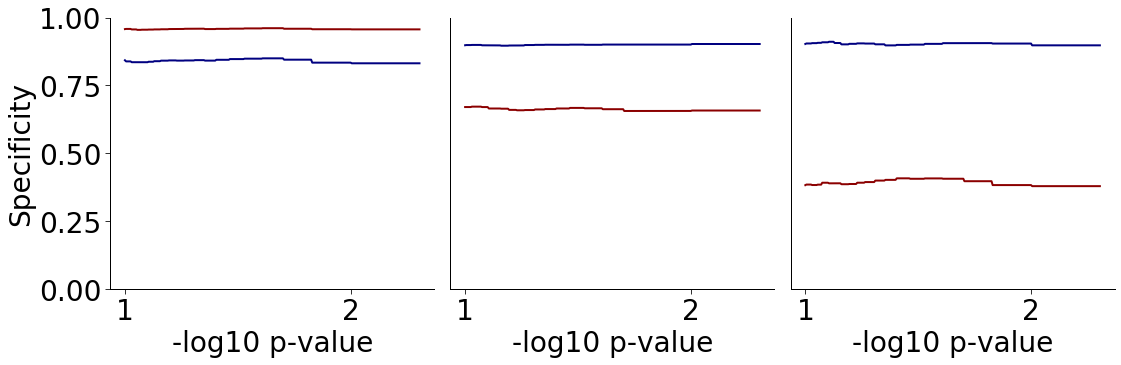

In [51]:
plot_dset_curves(chen_data, trapnell_data, song_data, 
                     which_curve = 3, p_max = 0.1, p_min = 0.005, steps = 0.005, ylims=(0, 0.8))

plot_dset_curves(chen_data, trapnell_data, song_data, 
                     which_curve = -2, p_max = 0.1, p_min = 0.005, steps = 0.005, ylims=(0, 1))

plot_dset_curves(chen_data, trapnell_data, song_data, 
                     which_curve = 0, p_max = 0.1, p_min = 0.005, steps = 0.005, ylims=(0, 1))

plot_dset_curves(chen_data, trapnell_data, song_data, 
                     which_curve = 1, p_max = 0.1, p_min = 0.005, steps = 0.005, ylims=(0, 1))

plot_dset_curves(chen_data, trapnell_data, song_data, 
                     which_curve = 2, p_max = 0.1, p_min = 0.005, steps = 0.005, ylims=(0, 1))

In [570]:
trapnell_prueba_dat = pd.read_csv('trapnell_exonwise_pvals.tab', sep='\t', index_col=0)

In [578]:
(np.abs((trapnell_prueba_dat - trapnell_exonwise_pvals)) <= 0.00000000000001).mean()

C_score    1.0
pvals      1.0
dtype: float64

In [574]:
trapnell_exonwise_pvals.head() == 

,C_score,pvals
AAMDC_3,0.011444,0.851485
AAMDC_5,0.008390,0.851485
ABI1_1,0.040493,0.287129
ABI1_8,0.161112,0.014851
ABL2_2,0.064566,0.019802


(array([8.60759494, 1.03291139, 1.26244726, 0.80337553, 0.94683544,
        0.86075949, 0.40168776, 0.60253165, 0.5164557 , 0.63122363,
        0.63122363, 0.68860759, 0.5164557 , 0.45907173, 0.3443038 ,
        0.5164557 , 0.40168776, 0.28691983, 0.37299578, 0.5164557 ]),
 array([0.00980392, 0.05882353, 0.10784314, 0.15686275, 0.20588235,
        0.25490196, 0.30392157, 0.35294118, 0.40196078, 0.45098039,
        0.5       , 0.54901961, 0.59803922, 0.64705882, 0.69607843,
        0.74509804, 0.79411765, 0.84313725, 0.89215686, 0.94117647,
        0.99019608]),
 <a list of 20 Patch objects>)

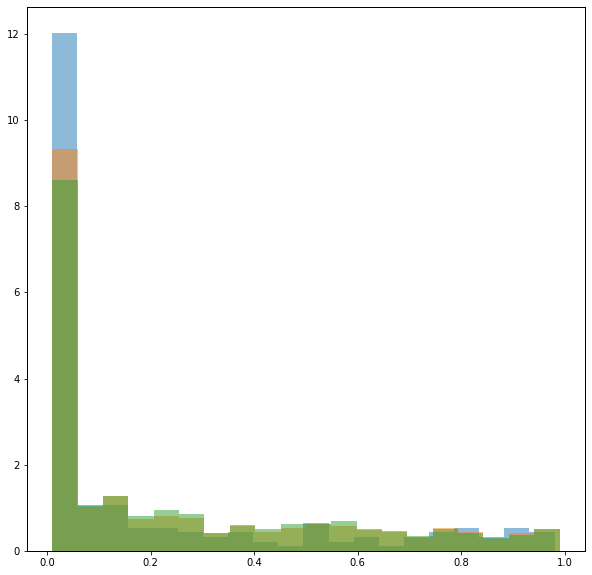

In [494]:
selected_mrna = [x for x in chen_filtered_lax[0].index[chen_filtered_lax[0].isna().mean(axis=1) <= 0.5] if x in chen_exonwise_pvals.index]

plt.hist(chen_exonwise_pvals.loc[selected_mrna, 'pvals'], density=True, alpha=0.5, bins=20)
plt.hist(chen_exonwise_pvals['pvals'], density=True, alpha=0.5, bins=20)
plt.hist(chen_exonwise_pvals.loc[[x for x in chen_exonwise_pvals.index if x not in selected_mrna], 'pvals'], density=True, alpha=0.5, bins=20)

In [497]:
len(chen_exonwise_pvals)

903

In [445]:
tiempo = t.time()
get_C(chen_PSI.loc['Rpn2_1'], W_chen)
print(t.time()-tiempo)

0.02757406234741211


In [446]:
prueba = (chen_PSI.loc['Rpn2_1'].dropna().values.reshape(-1, 1) - chen_PSI.loc['Rpn2_1'].dropna().values.reshape(1, -1))

In [449]:
prueba*prueba

array([[0.        , 0.01159763, 0.        , ..., 0.43183673, 0.5625    ,
        0.75111111],
       [0.01159763, 0.        , 0.01159763, ..., 0.30189591, 0.41255917,
        0.57604208],
       [0.        , 0.01159763, 0.        , ..., 0.43183673, 0.5625    ,
        0.75111111],
       ...,
       [0.43183673, 0.30189591, 0.43183673, ..., 0.        , 0.00862245,
        0.04390023],
       [0.5625    , 0.41255917, 0.5625    , ..., 0.00862245, 0.        ,
        0.01361111],
       [0.75111111, 0.57604208, 0.75111111, ..., 0.04390023, 0.01361111,
        0.        ]])

In [474]:
tiempo = t.time()
np.sum((prueba**2))
print(t.time()-tiempo)

0.0018208026885986328


In [475]:
tiempo = t.time()
np.sum((prueba*prueba))
print(t.time()-tiempo)

0.001962900161743164


In [504]:
pval_chen = pval_chen.loc[[x for x in pval_chen.index if 'mock_' not in x]]
pval_song = pval_song.loc[[x for x in pval_song.index if 'mock_' not in x]]
pval_lescroart = pval_lescroart.loc[[x for x in pval_lescroart.index if 'mock_' not in x]]
pval_trapnell = pval_trapnell.loc[[x for x in pval_trapnell.index if 'mock_' not in x]]

In [509]:
selected_mrna = [x for x in chen_filtered_lax[0].index[chen_filtered_lax[0].isna().mean(axis=1) <= 0.5] if x in pval_chen.index]


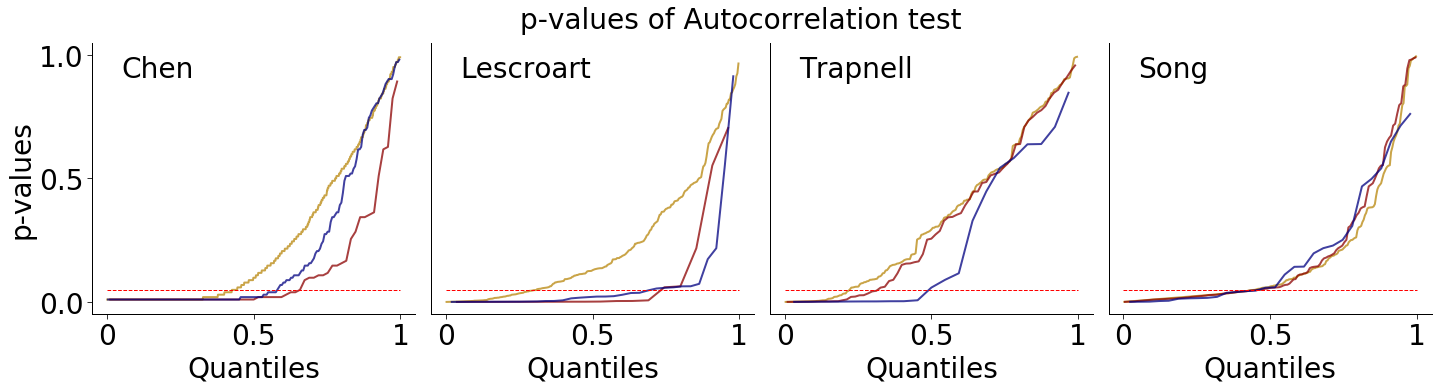

In [515]:
def plot_pvalues(ax, pval_df, filtered_PSI, rfiltered_PSI, min_obs = 0.5):
    
    selected_mrna = [x for x in filtered_PSI.index[filtered_PSI.isna().mean(axis=1) <= min_obs] if x in pval_df.index]
    selected_read = [x for x in rfiltered_PSI.index[rfiltered_PSI.isna().mean(axis=1) <= min_obs] if x in pval_df.index]

    
    current_palette = sns.color_palette('dark')
    
    pplot_1 = probplot(pval_df.pvals, dist='uniform')[0]
    pplot_2 = probplot(pval_df.loc[selected_read, 'pvals'], dist='uniform')[0]
#     pplot_3 = probplot(pvals.loc[selected_mrna_only, 'pvals'], dist='uniform')[0]
    pplot_4 = probplot(pval_df.loc[selected_mrna, 'pvals'], dist='uniform')[0]
    
    ax.plot(pplot_1[0], pplot_1[1], alpha = 0.75, c=current_palette[4], label='all exons', linewidth=2)
    ax.plot(pplot_2[0], pplot_2[1], alpha = 0.75, c='darkred', label='read filter', linewidth=2)
#     ax.plot(pplot_3[0], pplot_3[1], alpha = 0.75, c='forestgreen', label='mRNA only filter', linewidth=2)
    ax.plot(pplot_4[0], pplot_4[1], alpha = 0.75, c='navy', label='combined filter', linewidth=2)
    ax.plot([0, 1], [0.05, 0.05], 'r--', linewidth=1)
    ax.set_xlabel('Quantiles', fontsize=28)
    ax.tick_params(labelsize=28, length=5)
    
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    
    
    ax.set_xticks([0, 0.5, 1])
    ax.set_xticklabels(['0', '0.5', '1'])
    
    ax.tick_params(labelsize=28, length=5)
    
    
    
figsize(24, 5)
fig = plt.figure()

fig.suptitle('p-values of Autocorrelation test', fontsize=28)

gs = GridSpec(1,4)
gs.update(wspace=0.05, hspace=1.05)

ax_1 = fig.add_subplot(gs[0,0])
ax_2 = fig.add_subplot(gs[0,1])
ax_3 = fig.add_subplot(gs[0,2])
ax_4 = fig.add_subplot(gs[0,3])

ax_1.set_ylim((-0.05,1.05))
ax_2.set_ylim((-0.05,1.05))
ax_3.set_ylim((-0.05,1.05))
ax_4.set_ylim((-0.05,1.05))

plot_pvalues(ax_1, chen_exonwise_pvals, chen_filtered_lax[0], chen_filtered_lax_reads[0])
plot_pvalues(ax_2, pval_lescroart, lescroart_filtered_lax[0], lescroart_filtered_lax_reads[0])
plot_pvalues(ax_3, pval_trapnell, trapnell_filtered_lax[0], trapnell_filtered_lax_reads[0])
plot_pvalues(ax_4, pval_song, song_filtered_lax[0], song_filtered_lax_reads[0])

plt.setp(ax_2.get_yticklabels(), visible=False)
plt.setp(ax_3.get_yticklabels(), visible=False)
plt.setp(ax_4.get_yticklabels(), visible=False)
ax_2.yaxis.set_ticks_position('none')
ax_3.yaxis.set_ticks_position('none')
ax_4.yaxis.set_ticks_position('none')


ax_1.text(0.05, 1, 'Chen', fontsize=28, verticalalignment='top')
ax_2.text(0.05, 1, 'Lescroart', fontsize=28, verticalalignment='top')
ax_3.text(0.05, 1, 'Trapnell', fontsize=28, verticalalignment='top')
ax_4.text(0.05, 1, 'Song', fontsize=28, verticalalignment='top')

# ax_3.set_xticks([0, 0.5, 1], ['0', '0.5', '1'])
            
ax_1.set_ylabel('p-values', fontsize = 28)
# ax_4.legend(loc='center left', frameon=False, fontsize=14)

# plt.savefig('plots_review/figure3/autocorrelation/pvalues_3sets.svg', bbox_inches='tight', transparent=True)
# plt.savefig('plots_review/figure3/autocorrelation/pvalues_3sets.pdf', bbox_inches='tight', transparent=True)
# plt.savefig('plots_review/figure3/autocorrelation/pvalues_3sets.png', dpi=300, bbox_inches='tight', transparent=True)

plt.show()




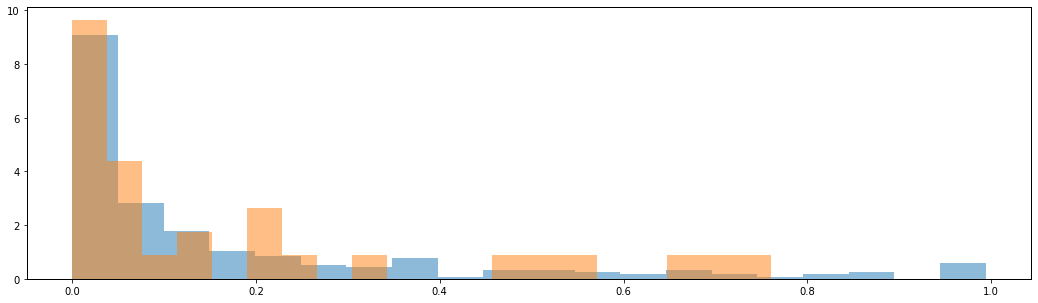

In [512]:
selected_mrna = [x for x in song_filtered_lax[0].index[song_filtered_lax[0].isna().mean(axis=1) <= 0.5] if x in pval_song.index]
plt.hist(pval_song['pvals'], alpha = 0.5, density=True, bins=20)
plt.hist(pval_song.loc[selected_mrna,'pvals'], alpha = 0.5, density=True, bins=20)
plt.show()

In [57]:
def run_autocorrelation_test_silent(PSI_tab, mrna_counts, 
                             pca, Ws, norm_PSI, min_mock_rounds = 100, max_mock_rounds = 100000):
    total_cells = len(PSI_tab.columns)

    test_exons = PSI_tab.index

    exon_list = []
    C_scores = []
    
    
    
    
#     print(test_exons)
    for exon in test_exons:
        exon_df = norm_PSI.loc[exon] # to make things faster
        exon_score = get_C(exon_df, Ws)
        mock_exons_tested = 0
        if exon_score >= 0:
            C_scores.append(exon_score)
            exon_list.append(exon)

            
            while True:
                
#                 i = mock_exons_tested + 1
#             for i in range(mock_rounds):
                scramble_cells = r.choice(norm_PSI.columns, total_cells, replace=False)
                mock_PSI = pd.DataFrame(norm_PSI.loc[exon, scramble_cells]).T
                mock_PSI.columns = PSI_tab.columns
                mock_df = mock_PSI.loc[exon]
#                 tiempo = t.time()
                mock_score = get_C(mock_df, Ws)
#                 print(t.time()-tiempo)
                if mock_score >= 0:
                    C_scores.append(mock_score)
                    exon_list.append('mock_'+exon+'_'+str(mock_exons_tested))
                    mock_exons_tested +=1
                    
                    if (mock_exons_tested > min_mock_rounds) and mock_score >= exon_score:
                        break
                    if mock_exons_tested > max_mock_rounds:
                        break
                    
        else:
            return ''
                    


    pvals = pd.DataFrame()
    pvals['C_score'] = C_scores
    pvals.index = exon_list
    
    
    n = len(pvals.C_score)
    pval_list = []

    for exon in pvals.index:
        C = pvals.loc[exon, 'C_score']
        x = np.sum(pvals.C_score > C)
        pvalue = (x+1)/(n+1)
        pval_list.append(pvalue)

    pvals['pvals'] = pval_list
    
    
    return pvals

def run_autocorrelation_test_exon_list(PSI_tab, mrna_counts, exon_list,
                             pca, Ws, norm_PSI, min_mock_rounds = 100, max_mock_rounds = 100000):
    
    pval_dataframe = pd.DataFrame()
    
    for exon in tqdm(exon_list):
        exon_pvals = run_autocorrelation_test_silent(pd.DataFrame(PSI_tab.loc[exon]).T, 
                                           mrna_counts, 
                             pca, Ws=Ws, min_mock_rounds = min_mock_rounds, max_mock_rounds = max_mock_rounds, 
                         norm_PSI = pd.DataFrame(norm_PSI.loc[exon]).T)
#         print(exon_pvals)
            
        if len(exon_pvals) > 0:
            pval_dataframe = pval_dataframe.append(pd.DataFrame(exon_pvals.loc[exon]).T)
        
    return pval_dataframe
    
    
 

In [59]:
# W_chen = get_distance_matrix(chen_pca_clust, k=244)
# chen_norm_PSI = get_signature_matrix(chen_PSI)

int_genes, int_exons = spu.get_int_events(chen_PSI, chen_mrna_counts, 0.05)
observed_exons = chen_PSI.index[chen_PSI.isna().mean(axis=1) <= (1-0.5)]
test_exons = [x for x in observed_exons if x in int_exons]

chen_exonwise_pvals_brute = run_autocorrelation_test_exon_list(chen_PSI, chen_mrna_counts, test_exons,
                             chen_pca_clust, W_chen, chen_norm_PSI)

HBox(children=(IntProgress(value=0, max=1176), HTML(value='')))

KeyboardInterrupt: 

In [6]:
def run_autocorrelation_test_silent(PSI_tab, mrna_counts, 
                             pca, Ws, norm_PSI, min_mock_rounds = 100, max_mock_rounds = 100000):
    total_cells = len(PSI_tab.columns)

    test_exons = PSI_tab.index

    exon_list = []
    C_scores = []
    
    
    
    
#     print(test_exons)
    for exon in test_exons:
        exon_df = norm_PSI.loc[exon] # to make things faster
        exon_score = get_C(exon_df, Ws)
        mock_exons_tested = 0
        if exon_score >= 0:
            C_scores.append(exon_score)
            exon_list.append(exon)

            
            while True:
                
#                 i = mock_exons_tested + 1
#             for i in range(mock_rounds):
                scramble_cells = r.choice(norm_PSI.columns, total_cells, replace=False)
                mock_PSI = pd.DataFrame(norm_PSI.loc[exon, scramble_cells]).T
                mock_PSI.columns = PSI_tab.columns
                mock_df = mock_PSI.loc[exon]
#                 tiempo = t.time()
                mock_score = get_C(mock_df, Ws)
#                 print(t.time()-tiempo)
                if mock_score >= 0:
                    C_scores.append(mock_score)
                    exon_list.append('mock_'+exon+'_'+str(mock_exons_tested))
                    mock_exons_tested +=1
                    
                    if (mock_exons_tested > min_mock_rounds) and mock_score >= exon_score:
                        break
                    if mock_exons_tested > max_mock_rounds:
                        break
                    
        else:
            return ''
                    


    pvals = pd.DataFrame()
    pvals['C_score'] = C_scores
    pvals.index = exon_list
    
    
    n = len(pvals.C_score)
    pval_list = []

    for exon in pvals.index:
        C = pvals.loc[exon, 'C_score']
        x = np.sum(pvals.C_score > C)
        pvalue = (x+1)/(n+1)
        pval_list.append(pvalue)

    pvals['pvals'] = pval_list
    
    
    return pvals



def run_autocorrelation_test_exon_list(PSI_tab, mrna_counts, exon_list,
                             pca, Ws, norm_PSI, min_mock_rounds = 100, max_mock_rounds = 100000):
    
    pval_dataframe = pd.DataFrame()
    
    for exon in tqdm(exon_list):
        exon_pvals = run_autocorrelation_test_silent(pd.DataFrame(PSI_tab.loc[exon]).T, 
                                           mrna_counts, 
                             pca, Ws=Ws, min_mock_rounds = min_mock_rounds, max_mock_rounds = max_mock_rounds, 
                         norm_PSI = pd.DataFrame(norm_PSI.loc[exon]).T)
#         print(exon_pvals)
            
        if len(exon_pvals) > 0:
            pval_dataframe = pval_dataframe.append(pd.DataFrame(exon_pvals.loc[exon]).T)
        
    return pval_dataframe
    
    
 

In [7]:
exons_05_10 = chen_PSI.index[(np.abs(0.5 - chen_PSI.mean(axis = 1))>0.4) & (np.abs(0.5 - chen_PSI.mean(axis = 1))<=0.45)] 
exons_10_20 = chen_PSI.index[(np.abs(0.5 - chen_PSI.mean(axis = 1))>0.3) & (np.abs(0.5 - chen_PSI.mean(axis = 1))<=0.40)] 
exons_20_30 = chen_PSI.index[(np.abs(0.5 - chen_PSI.mean(axis = 1))>0.2) & (np.abs(0.5 - chen_PSI.mean(axis = 1))<=0.30)] 
exons_30_40 = chen_PSI.index[(np.abs(0.5 - chen_PSI.mean(axis = 1))>0.1) & (np.abs(0.5 - chen_PSI.mean(axis = 1))<=0.20)] 
exons_40_50 = chen_PSI.index[(np.abs(0.5 - chen_PSI.mean(axis = 1))<=0.1)] 

exons_obs_50_60 = chen_PSI.index[(chen_PSI.isna().mean(axis=1) <= 0.5) & (chen_PSI.isna().mean(axis=1) > 0.4)]
exons_obs_60_70 = chen_PSI.index[(chen_PSI.isna().mean(axis=1) <= 0.4) & (chen_PSI.isna().mean(axis=1) > 0.3)]
exons_obs_70_80 = chen_PSI.index[(chen_PSI.isna().mean(axis=1) <= 0.3) & (chen_PSI.isna().mean(axis=1) > 0.2)]
exons_obs_80_90 = chen_PSI.index[(chen_PSI.isna().mean(axis=1) <= 0.2) & (chen_PSI.isna().mean(axis=1) > 0.1)]
exons_obs_90_100 = chen_PSI.index[(chen_PSI.isna().mean(axis=1) <= 0.1)]

list1 = [exons_05_10, exons_10_20, exons_20_30, exons_30_40, exons_40_50]
list2 = [exons_obs_50_60, exons_obs_60_70, exons_obs_70_80, exons_obs_80_90, exons_obs_90_100]


In [8]:
def make_mock_C_scores(norm_PSI, Ws, exon_list, total_cells, mock=100000):
    exon_out_list = []
    C_scores = []
    for i in tqdm(range(mock)):
        mock_run = True
        while mock_run:
            exon = r.choice(exon_list, 1)[0]
#             print(exon)
            scramble_cells = r.choice(norm_PSI.columns, total_cells, replace=False)
            mock_PSI = pd.DataFrame(norm_PSI.loc[exon, scramble_cells]).T

#             print(mock_PSI.shape)
#             print(norm_PSI.shape)

            mock_PSI.columns = norm_PSI.columns
            mock_df = mock_PSI.loc[exon]
#             print(type(mock_df))
#             print(mock_df)
            mock_score = get_C(mock_df, Ws)
            
#             print(mock_score)

            if mock_score >= 0:
                C_scores.append(mock_score)
                exon_out_list.append('mock_'+exon+'_'+str(i))
                mock_run = False
    return exon_out_list, C_scores
                    
def get_C(exon_score, W):
    exon_score = exon_score.dropna()
    obs_cells = exon_score.index
#     print(exon_score)
    x = (exon_score.values.reshape(-1, 1) - exon_score.values.reshape(1, -1))
#     print(x)
    w = W.loc[obs_cells, obs_cells]
    num = (len(obs_cells)-1)*((w*(x**2)).sum().sum())
#     print(num)
    den = (2*w.sum().sum())*np.sum((exon_score - exon_score.mean())**2)
#     print(den)
    C = num/den
    score = 1 - C
    return score
    

In [45]:
# W_chen = get_distance_matrix(chen_pca_clust, k=244)
# chen_norm_PSI = get_signature_matrix(chen_PSI)
exon_out_list, C_scores = make_mock_C_scores(chen_norm_PSI, W_chen, list1[0]&list2[0], 488, mock=500)

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

(array([160., 122.,  90.,  58.,  35.,  19.,   9.,   5.,   1.,   1.]),
 array([1.02409555e-05, 1.90490628e-02, 3.80878847e-02, 5.71267066e-02,
        7.61655284e-02, 9.52043503e-02, 1.14243172e-01, 1.33281994e-01,
        1.52320816e-01, 1.71359638e-01, 1.90398460e-01]),
 <a list of 10 Patch objects>)

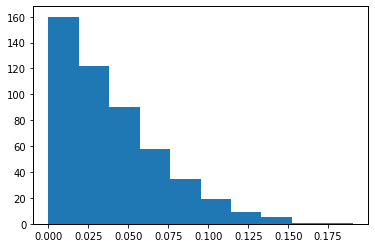

In [46]:
plt.hist(C_scores)

In [47]:
fit_alpha, fit_loc, fit_beta = st.gamma.fit(C_scores)

In [48]:
random_data = st.gamma.rvs(fit_alpha, loc=fit_loc, scale=fit_beta, size=10000)

In [49]:
random_data

array([0.05274603, 0.01529252, 0.02201442, ..., 0.01231354, 0.04075646,
       0.02001159])

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

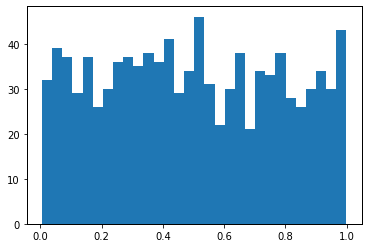

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

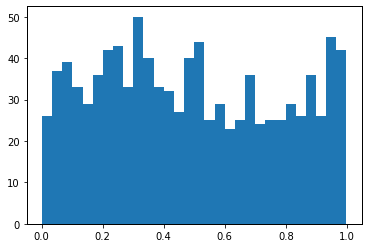

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

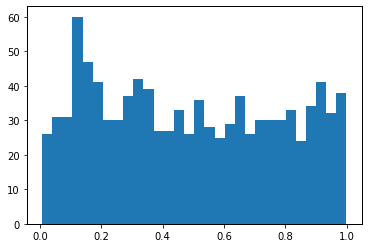

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

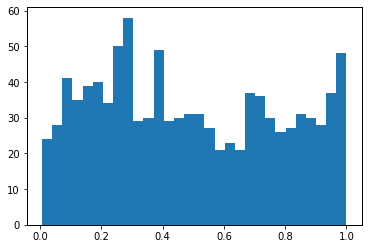

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

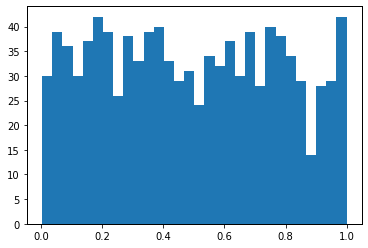

In [69]:
for i in range(5):
    exon_out_list, C_scores = make_mock_C_scores(chen_norm_PSI, W_chen, list1[0]&list2[0], 488, mock=1000)
    fit_alpha, fit_loc, fit_beta = st.gamma.fit(C_scores)
    random_data = st.gamma.rvs(fit_alpha, loc=fit_loc, scale=fit_beta, size=10000)
    p_vals_gamma = []
    for d in C_scores:
        pv = (np.sum(random_data > d) + 1)/(len(random_data)+1)
        p_vals_gamma.append(pv)
    # plt.hist(random_data)
    plt.hist(p_vals_gamma, bins=30)
    plt.show()

In [56]:
st.chi2.fit(data)

(0.45675855753704875, 0.000180727187780616, 1.3988608833718472)

In [59]:
np.random.chisquare(fit_alpha, loc=fit_loc, scale=fit_beta, size=10000)

TypeError: chisquare() got an unexpected keyword argument 'loc'

In [61]:
st.chi2.rvs(fit_alpha, loc=fit_loc, scale=fit_beta, size=10000)

array([0.08165029, 0.00891354, 0.02863294, ..., 0.01059756, 0.0513463 ,
       0.04252017])

/home/cfbuenabadn/anaconda3/lib/python3.6/site-packages/pandas/plotting/_core.py:1337: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  n, bins, patches = ax.hist(y, bins=bins, bottom=bottom, **kwds)


KeyboardInterrupt: 

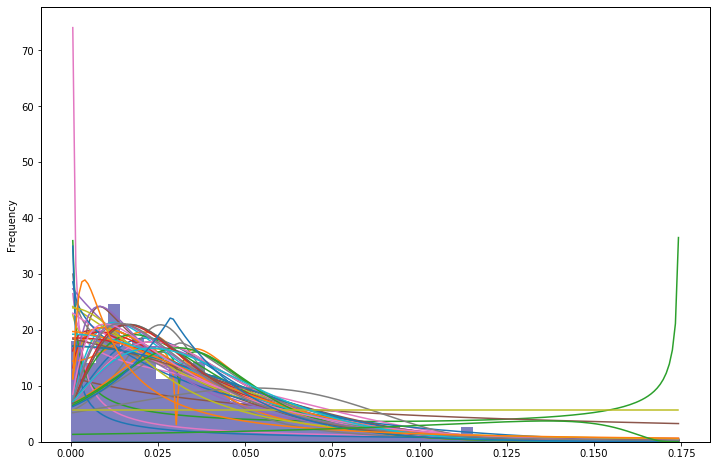

In [70]:

%matplotlib inline

import warnings
import numpy as np
import pandas as pd
import scipy.stats as st
import statsmodels as sm
import matplotlib
import matplotlib.pyplot as plt

# matplotlib.rcParams['figure.figsize'] = (16.0, 12.0)
# matplotlib.style.use('ggplot')

# Create models from data
def best_fit_distribution(data, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Distributions to check
    DISTRIBUTIONS = [        
        st.alpha,st.anglit,st.arcsine,st.beta,st.betaprime,st.bradford,st.burr,st.cauchy,st.chi,st.chi2,st.cosine,
        st.dgamma,st.dweibull,st.erlang,st.expon,st.exponnorm,st.exponweib,st.exponpow,st.f,st.fatiguelife,st.fisk,
        st.foldcauchy,st.foldnorm,st.frechet_r,st.frechet_l,st.genlogistic,st.genpareto,st.gennorm,st.genexpon,
        st.genextreme,st.gausshyper,st.gamma,st.gengamma,st.genhalflogistic,st.gilbrat,st.gompertz,st.gumbel_r,
        st.gumbel_l,st.halfcauchy,st.halflogistic,st.halfnorm,st.halfgennorm,st.hypsecant,st.invgamma,st.invgauss,
        st.invweibull,st.johnsonsb,st.johnsonsu,st.ksone,st.kstwobign,st.laplace,st.levy,st.levy_l,st.levy_stable,
        st.logistic,st.loggamma,st.loglaplace,st.lognorm,st.lomax,st.maxwell,st.mielke,st.nakagami,st.ncx2,st.ncf,
        st.nct,st.norm,st.pareto,st.pearson3,st.powerlaw,st.powerlognorm,st.powernorm,st.rdist,st.reciprocal,
        st.rayleigh,st.rice,st.recipinvgauss,st.semicircular,st.t,st.triang,st.truncexpon,st.truncnorm,st.tukeylambda,
        st.uniform,st.vonmises,st.vonmises_line,st.wald,st.weibull_min,st.weibull_max,st.wrapcauchy
    ]

    # Best holders
    best_distribution = st.norm
    best_params = (0.0, 1.0)
    best_sse = np.inf

    # Estimate distribution parameters from data
    for distribution in DISTRIBUTIONS:

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))

                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax)
                    end
                except Exception:
                    pass

                # identify if this distribution is better
                if best_sse > sse > 0:
                    best_distribution = distribution
                    best_params = params
                    best_sse = sse

        except Exception:
            pass

    return (best_distribution.name, best_params)

def make_pdf(dist, params, size=10000):
    """Generate distributions's Probability Distribution Function """

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf

# Load data from statsmodels datasets
data = pd.Series(C_scores)

# Plot for comparison
plt.figure(figsize=(12,8))
ax = data.plot(kind='hist', bins=50, normed=True, alpha=0.5, color='navy')
# Save plot limits
dataYLim = ax.get_ylim()

# Find best fit distribution
best_fit_name, best_fit_params = best_fit_distribution(data, 200, ax)
best_dist = getattr(st, best_fit_name)

# Update plots
ax.set_ylim(dataYLim)
ax.set_title(u'El Niño sea temp.\n All Fitted Distributions')
ax.set_xlabel(u'Temp (°C)')

In [15]:
data

0      0.046746
1      0.012916
2      0.014227
3      0.100101
4      0.103750
5      0.031398
6      0.011190
7      0.007287
8      0.030018
9      0.014989
10     0.030117
11     0.008386
12     0.051160
13     0.032775
14     0.051378
15     0.018066
16     0.046133
17     0.036014
18     0.024698
19     0.002002
20     0.019036
21     0.037930
22     0.044895
23     0.062484
24     0.063649
25     0.030960
26     0.029420
27     0.006199
28     0.106263
29     0.052919
         ...   
470    0.027342
471    0.021382
472    0.020714
473    0.017565
474    0.011759
475    0.052803
476    0.022141
477    0.057460
478    0.031194
479    0.026896
480    0.046549
481    0.035978
482    0.004213
483    0.057256
484    0.008448
485    0.069704
486    0.031631
487    0.020096
488    0.052727
489    0.017004
490    0.021890
491    0.019201
492    0.006322
493    0.043550
494    0.015587
495    0.006580
496    0.022145
497    0.012499
498    0.055413
499    0.000483
Length: 500, dtype: floa

In [ ]:
exon_out_list = []
C_score_list = []


for lista_1 in list1:
    for lista_2 in list2:
        combination = lista_1 & lista_2
        if len(combination) > 0:
            exon_out_list, C_scores = make_mock_C_scores(chen_norm_PSI, W_chen, lista_1&lista_2, 488, mock=500)

HBox(children=(IntProgress(value=0, max=10000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=10000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=10000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=10000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=10000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=10000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=10000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=10000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=10000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=10000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=10000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=10000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=10000), HTML(value='')))

In [102]:
C_scores

[0.04953334402531884,
 0.032348925737078704,
 0.03312018132873973,
 0.018805193134420306,
 0.07532480835120459,
 0.07704449057323481,
 0.014670367536060436,
 0.006938213223142253,
 0.01088043964383012,
 0.0299581233142856]